# Customer Prediction

## Environment Setting

In [78]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Visualization
from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay
import shap

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek

# Outlier Detection
from sklearn.ensemble import IsolationForest

# Modeling and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve,
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, precision_recall_curve, auc
)

# Graph Analysis (optional, if used)
import networkx as nx

## Step 1: Data Exploration and Cleaning

### Check

In [7]:
customer = pd.read_csv(r"D:\customer\Customer Churn Prediction.csv")
print(f"Dataset shape: {customer.shape}")

Dataset shape: (7043, 21)


In [8]:
# Check the number of unique values in each column
unique_counts = customer.nunique()
print("\nNumber of unique values per column:\n", unique_counts)

# Check the data type of each column
data_types = customer.dtypes
print("\nData types of each column:\n", data_types)

# Display unique values for columns with few unique entries (<=10)
for col in customer.columns:
    unique_vals = customer[col].unique()
    num_unique_vals = len(unique_vals)
    if num_unique_vals <= 10:
        print(f"\nColumn: {col} (Unique values: {num_unique_vals})")
        print(unique_vals)


Number of unique values per column:
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Data types of each column:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
Str

In [9]:
# check data types
print("\nUpdated Data Types:\n", customer.dtypes)


Updated Data Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [10]:
# Convert categorical variables to category dtype
categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                       'PhoneService', 'MultipleLines', 'InternetService', 
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
                       
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
    
# Convert TotalCharges to float64 (handle possible non-numeric values)
customer['TotalCharges'] = pd.to_numeric(customer['TotalCharges'], errors='coerce')

# Ensure MonthlyCharges is float64
customer['MonthlyCharges'] = customer['MonthlyCharges'].astype('float64')

In [11]:
# Drop rows with missing values in the TotalCharges column
customer = customer.dropna(subset=['TotalCharges'])

# Confirm that missing values have been removed
print(f"Number of rows after removing missing values: {customer.shape[0]}")
print(f"Number of missing values in TotalCharges column: {customer['TotalCharges'].isna().sum()}")

Number of rows after removing missing values: 7032
Number of missing values in TotalCharges column: 0


In [12]:
# check statistics of the dataset
# 1. Calculate churn rate
churn_rate = customer['Churn'].value_counts(normalize=True) * 100
print("\nChurn Rate:")
print(churn_rate)


Churn Rate:
Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


In [13]:
# 2, demographic statistics
# demographic variables
demographic_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# Calculate the distribution of Churn for each demographic variable
print("\nChurn Rate by Demographics:")
for var in demographic_vars:
    churn_by_demo = customer.groupby(var)['Churn'].value_counts(normalize=True).unstack() * 100
    print(f"\n{var} vs Churn:")
    print(churn_by_demo)


Churn Rate by Demographics:

gender vs Churn:
Churn          No        Yes
gender                      
Female  73.040482  26.959518
Male    73.795435  26.204565

SeniorCitizen vs Churn:
Churn                 No        Yes
SeniorCitizen                      
0              76.349745  23.650255
1              58.318739  41.681261

Partner vs Churn:
Churn           No        Yes
Partner                      
No       67.023908  32.976092
Yes      80.282935  19.717065

Dependents vs Churn:
Churn              No        Yes
Dependents                      
No          68.720860  31.279140
Yes         84.468795  15.531205


C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\3236181766.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_demo = customer.groupby(var)['Churn'].value_counts(normalize=True).unstack() * 100
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\3236181766.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_demo = customer.groupby(var)['Churn'].value_counts(normalize=True).unstack() * 100
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\3236181766.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to r

In [14]:
# Account and service related variables
service_vars = ['tenure', 'Contract', 'InternetService', 'StreamingTV', 'StreamingMovies']

print("\nChurn Rate by Account & Service Variables:")
for var in service_vars:
    if customer[var].dtype == 'object': 
        churn_by_service = customer.groupby(var)['Churn'].value_counts(normalize=True).unstack() * 100
        print(f"\n{var} vs Churn:")
        print(churn_by_service)
    else: 
        print(f"\n{var} statistics by Churn:")
        print(customer.groupby('Churn')[var].describe())


Churn Rate by Account & Service Variables:

tenure statistics by Churn:
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
No     5163.0  37.650010  24.076940  1.0  15.0  38.0  61.0  72.0
Yes    1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0

Contract statistics by Churn:
      count unique             top  freq
Churn                                   
No     5163      3  Month-to-month  2220
Yes    1869      3  Month-to-month  1655

InternetService statistics by Churn:
      count unique          top  freq
Churn                                
No     5163      3          DSL  1957
Yes    1869      3  Fiber optic  1297

StreamingTV statistics by Churn:
      count unique  top  freq
Churn                        
No     5163      3  Yes  1889
Yes    1869      3   No   942

StreamingMovies statistics by Churn:
      count unique  top  freq
Churn                        
No     5163      3  Yes  1913


C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2214077412.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(customer.groupby('Churn')[var].describe())
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2214077412.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(customer.groupby('Churn')[var].describe())
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2214077412.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence thi

In [15]:
# Billing and payment related variables
billing_vars = ['MonthlyCharges', 'PaymentMethod']

print("\nChurn Rate by Billing Variables:")
for var in billing_vars:
    if customer[var].dtype == 'object': 
        churn_by_billing = customer.groupby(var)['Churn'].value_counts(normalize=True).unstack() * 100
        print(f"\n{var} vs Churn:")
        print(churn_by_billing)
    else: 
        print(f"\n{var} statistics by Churn:")
        print(customer.groupby('Churn')[var].describe())


Churn Rate by Billing Variables:

MonthlyCharges statistics by Churn:
        count       mean        std    min    25%    50%     75%     max
Churn                                                                   
No     5163.0  61.307408  31.094557  18.25  25.10  64.45  88.475  118.75
Yes    1869.0  74.441332  24.666053  18.85  56.15  79.65  94.200  118.35

PaymentMethod statistics by Churn:
      count unique               top  freq
Churn                                     
No     5163      4      Mailed check  1296
Yes    1869      4  Electronic check  1071


C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\522384938.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(customer.groupby('Churn')[var].describe())
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\522384938.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(customer.groupby('Churn')[var].describe())


### Visulization

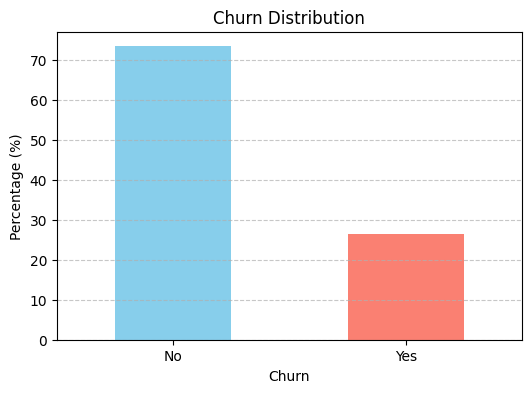

In [16]:
# Part 1:

# Caculate churn distribution
churn_counts = customer['Churn'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(6,4))
churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\3892158799.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_var = customer.groupby(var)['Churn'].value_counts(normalize=True).unstack() * 100
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\3892158799.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_var = customer.groupby(var)['Churn'].value_counts(normalize=True).unstack() * 100
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\3892158799.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to ret

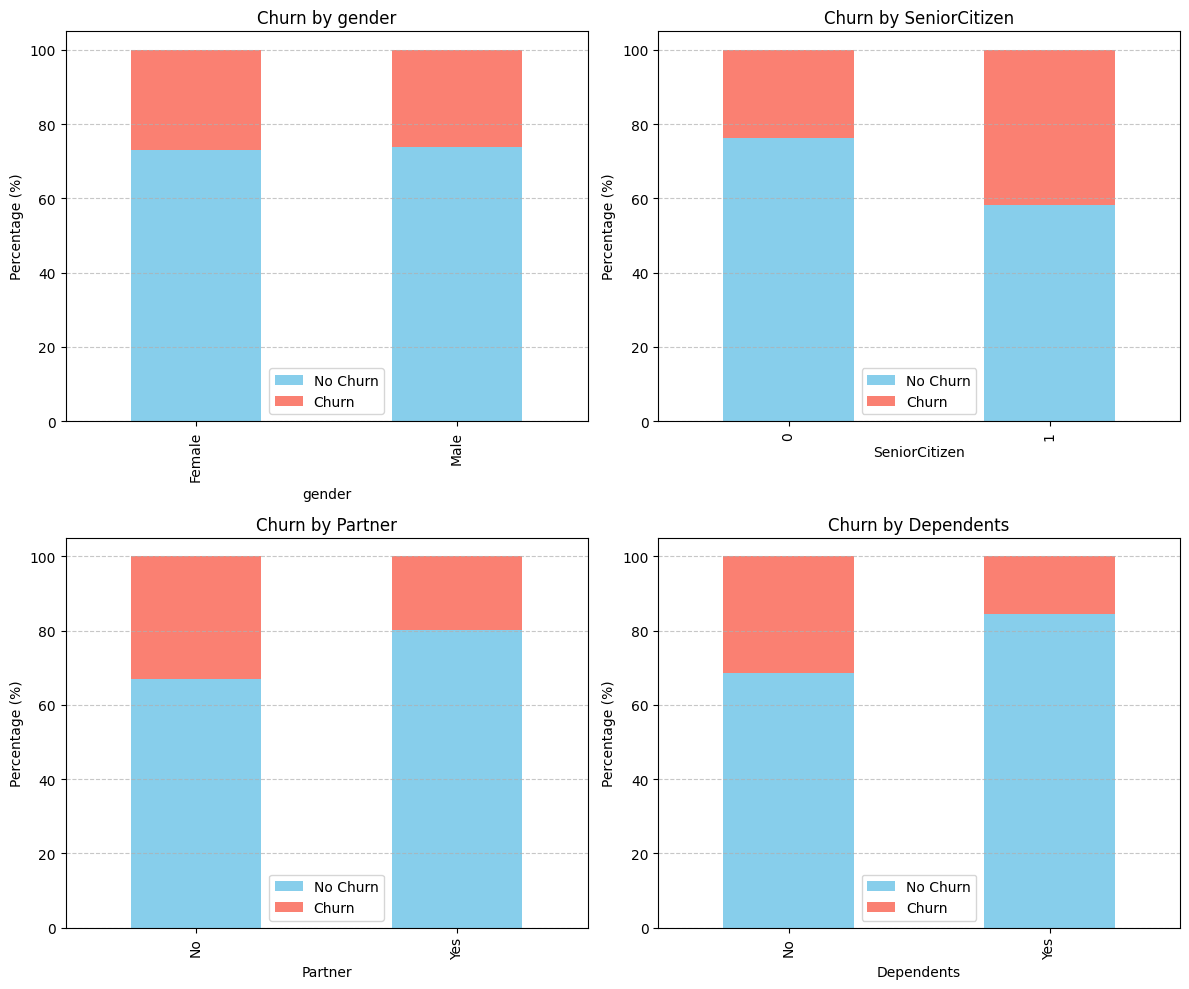

In [17]:
# Part 2: Analyze Churn by Demographic Variables

demographic_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 

for i, var in enumerate(demographic_vars):
    ax = axes[i//2, i%2] 
    churn_by_var = customer.groupby(var)['Churn'].value_counts(normalize=True).unstack() * 100
    churn_by_var.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'salmon'])
    ax.set_title(f'Churn by {var}')
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel(var)
    ax.legend(['No Churn', 'Churn'])
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\1887633042.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contract_churn = customer.groupby('Contract')['Churn'].value_counts(normalize=True).unstack() * 100


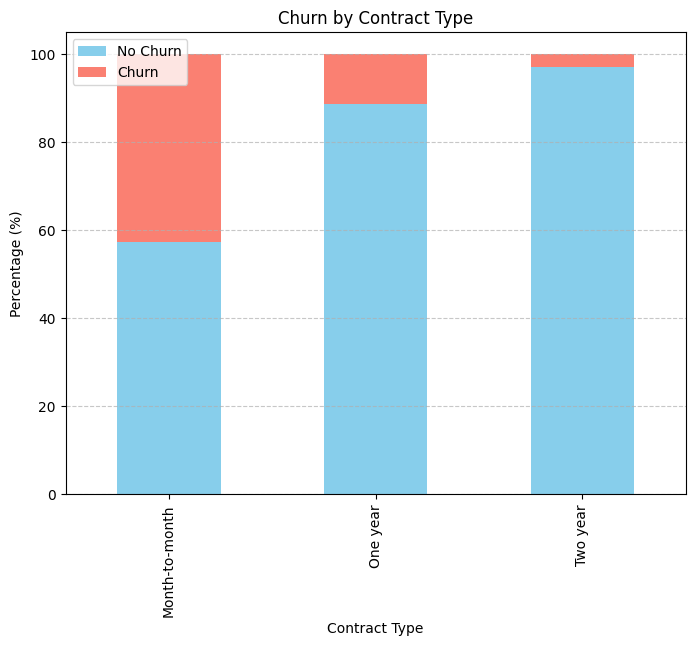

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\1887633042.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  payment_churn = customer.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack() * 100


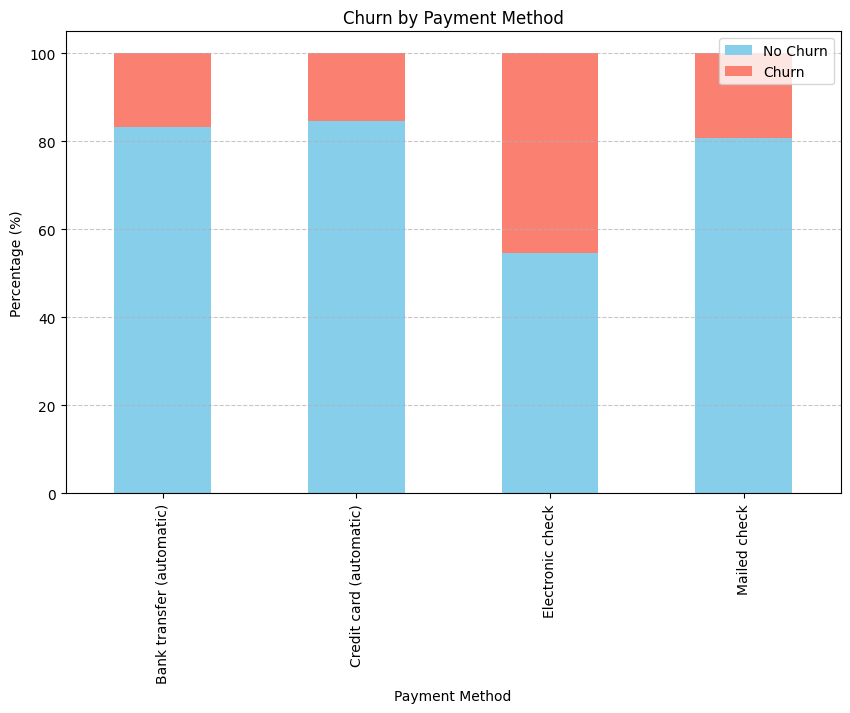

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\1887633042.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='tenure', data=customer, palette='Set2')


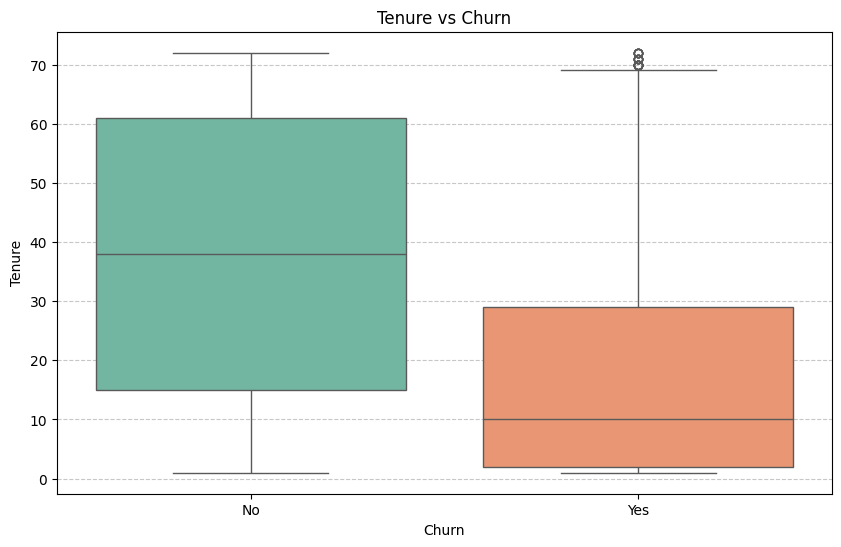

In [18]:
# Part 3:

# Churn distribution by contract type
contract_churn = customer.groupby('Contract')['Churn'].value_counts(normalize=True).unstack() * 100

contract_churn.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], figsize=(8, 6))
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Percentage (%)')
plt.legend(['No Churn', 'Churn'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Churn distribution by payment method
payment_churn = customer.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack() * 100

payment_churn.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], figsize=(10, 6))
plt.title('Churn by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Percentage (%)')
plt.legend(['No Churn', 'Churn'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='tenure', data=customer, palette='Set2')
plt.title('Tenure vs Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2185167226.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  internet_churn = customer.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack() * 100


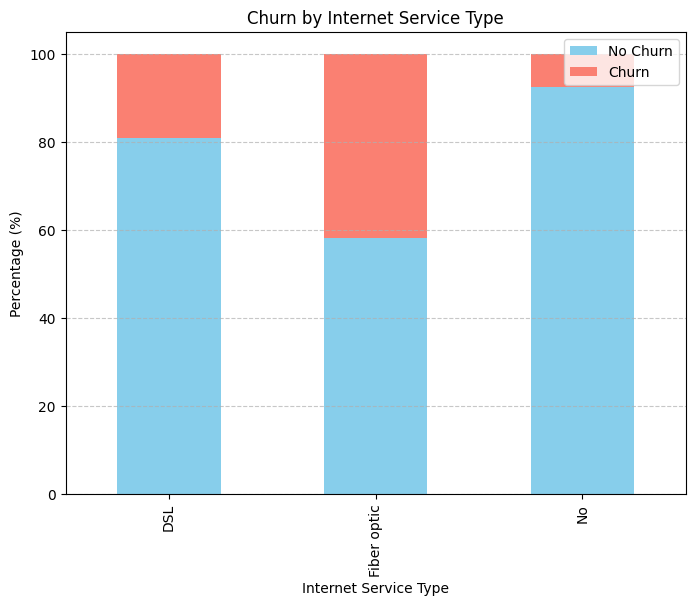

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2185167226.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_service = customer.groupby(var)['Churn'].value_counts(normalize=True).unstack() * 100
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2185167226.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_service = customer.groupby(var)['Churn'].value_counts(normalize=True).unstack() * 100


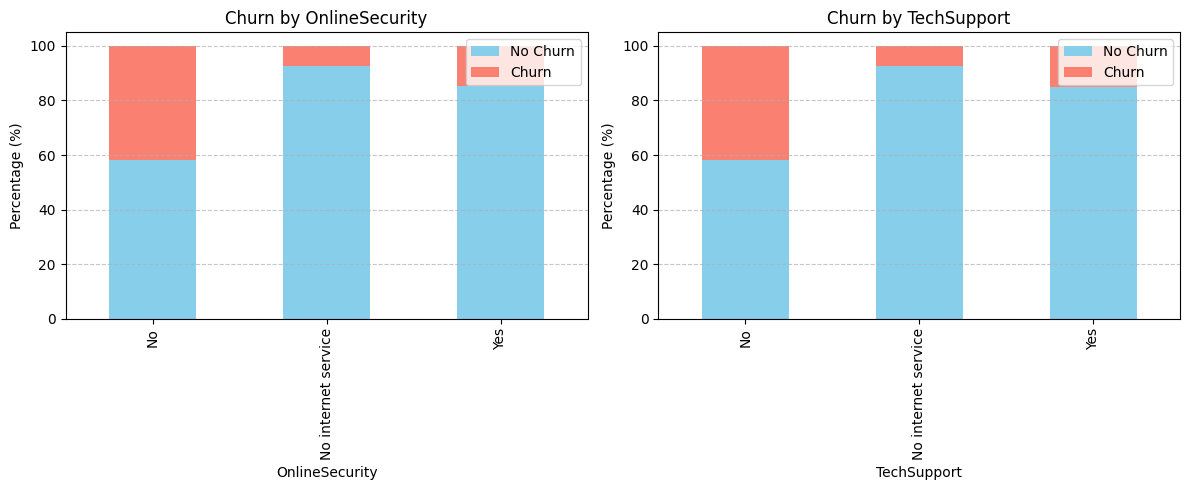

In [19]:
# Part 4:

# View Churn distribution by Internet service type
internet_churn = customer.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack() * 100

internet_churn.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], figsize=(8, 6))
plt.title('Churn by Internet Service Type')
plt.xlabel('Internet Service Type')
plt.ylabel('Percentage (%)')
plt.legend(['No Churn', 'Churn'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

addon_services = ['OnlineSecurity', 'TechSupport']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

for i, var in enumerate(addon_services):
    ax = axes[i]
    churn_by_service = customer.groupby(var)['Churn'].value_counts(normalize=True).unstack() * 100
    churn_by_service.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'salmon'])
    ax.set_title(f'Churn by {var}')
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel(var)
    ax.legend(['No Churn', 'Churn'])
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\3339723486.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='MonthlyCharges', data=customer, palette=['skyblue', 'salmon'])


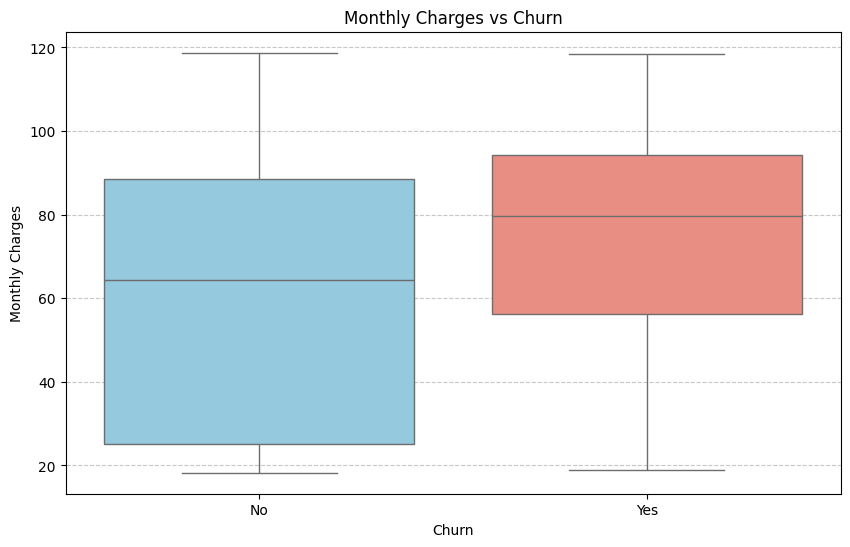

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\3339723486.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='TotalCharges', data=customer, palette=['skyblue', 'salmon'])


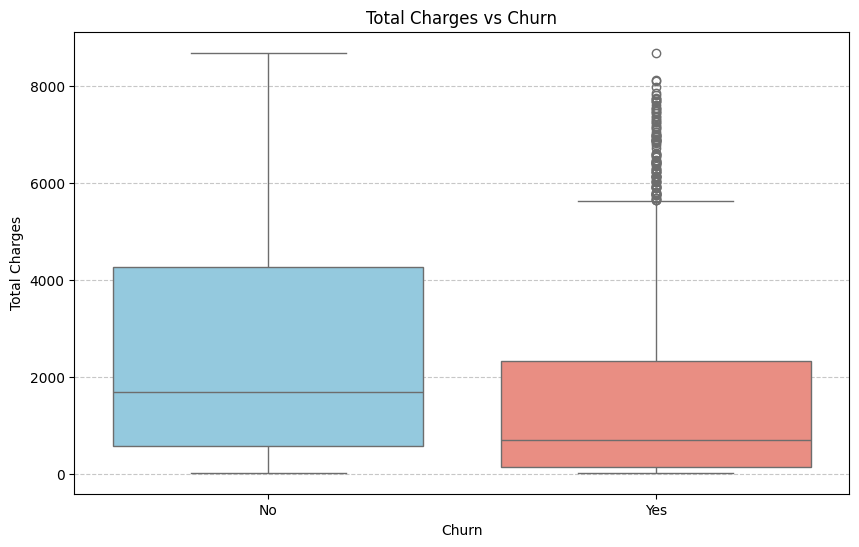

In [20]:
# Part 5

# Churn vs Monthly Charges
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=customer, palette=['skyblue', 'salmon'])
plt.title('Monthly Charges vs Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Churn vs Total Charges
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=customer, palette=['skyblue', 'salmon'])
plt.title('Total Charges vs Churn')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

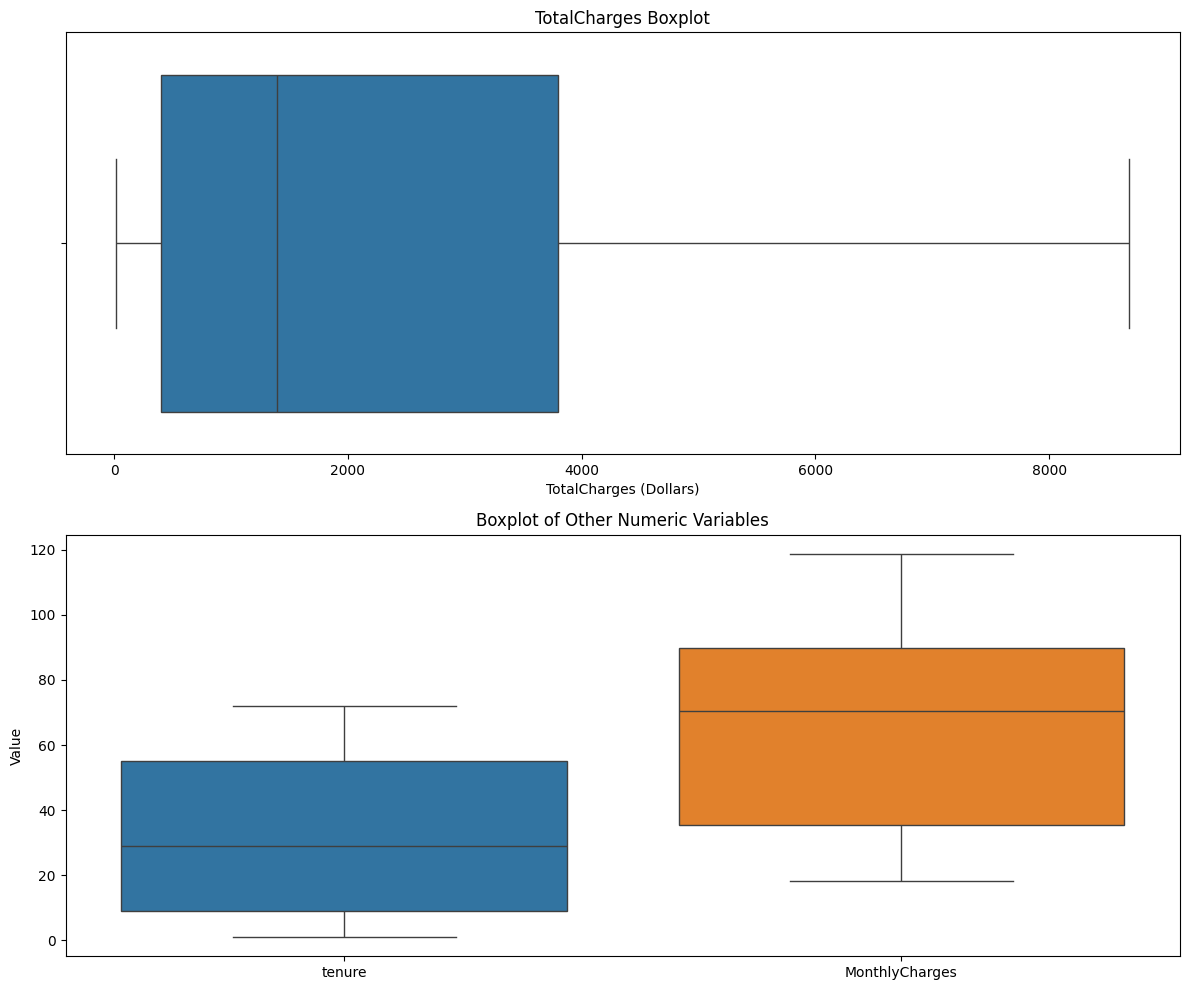

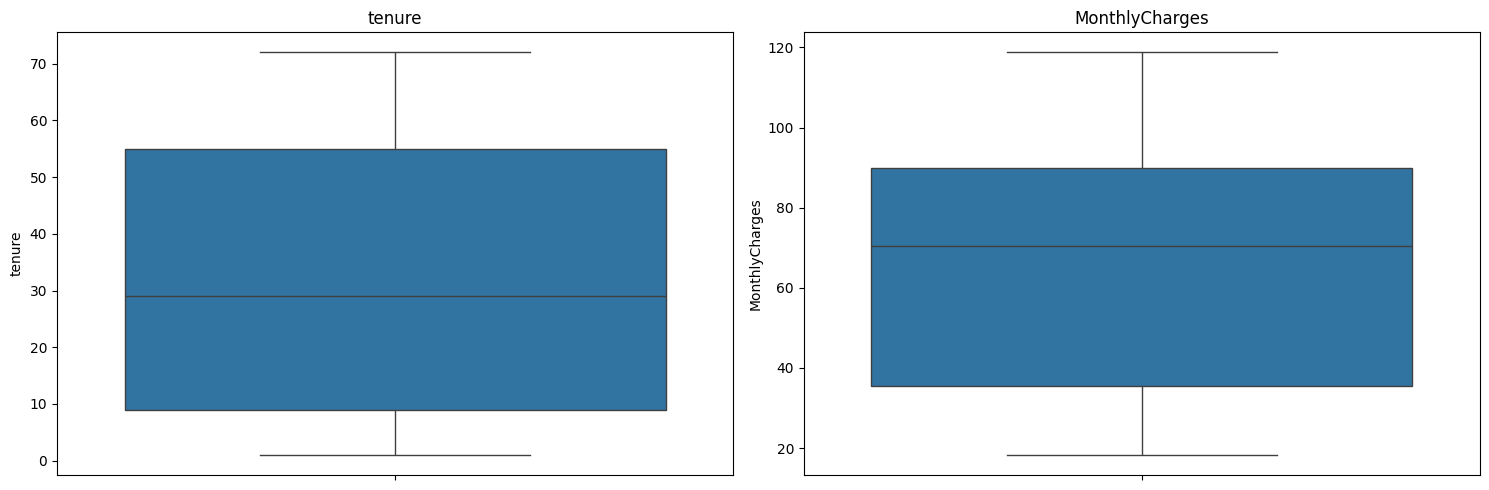


tenure:
  - Range: [1, 72]
  - Quartiles: Q1=9.00, Median=29.00, Q3=55.00
  - Outlier Thresholds: [-60.00, 124.00]
  - Number of Outliers: 0 (0.00%)

MonthlyCharges:
  - Range: [18.25, 118.75]
  - Quartiles: Q1=35.59, Median=70.35, Q3=89.86
  - Outlier Thresholds: [-45.82, 171.27]
  - Number of Outliers: 0 (0.00%)

TotalCharges:
  - Range: [18.8, 8684.8]
  - Quartiles: Q1=401.45, Median=1397.47, Q3=3794.74
  - Outlier Thresholds: [-4688.48, 8884.67]
  - Number of Outliers: 0 (0.00%)


In [22]:
# Part 6: Outliers Checking with Boxplots

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

sns.boxplot(x=customer['TotalCharges'], ax=axes[0])
axes[0].set_title('TotalCharges Boxplot')
axes[0].set_xlabel('TotalCharges (Dollars)')

other_numeric = [col for col in customer.select_dtypes(include=['float64', 'int64']).columns 
                if col != 'TotalCharges']

customer_other = customer[other_numeric]

sns.boxplot(data=customer_other, ax=axes[1])
axes[1].set_title('Boxplot of Other Numeric Variables')
axes[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(other_numeric), figsize=(15, 5))

for i, col in enumerate(other_numeric):
    sns.boxplot(y=customer[col], ax=axes[i])
    axes[i].set_title(col)
    
plt.tight_layout()
plt.show()

# Print outlier statistics for each numeric column
for col in customer.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = customer[col].quantile(0.25)
    Q3 = customer[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = customer[(customer[col] < lower_bound) | (customer[col] > upper_bound)]
    outlier_count = len(outliers)
    
    print(f"\n{col}:")
    print(f"  - Range: [{customer[col].min()}, {customer[col].max()}]")
    print(f"  - Quartiles: Q1={Q1:.2f}, Median={customer[col].median():.2f}, Q3={Q3:.2f}")
    print(f"  - Outlier Thresholds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  - Number of Outliers: {outlier_count} ({(outlier_count/len(customer))*100:.2f}%)")


Number of Outliers: 352 (5.01%)


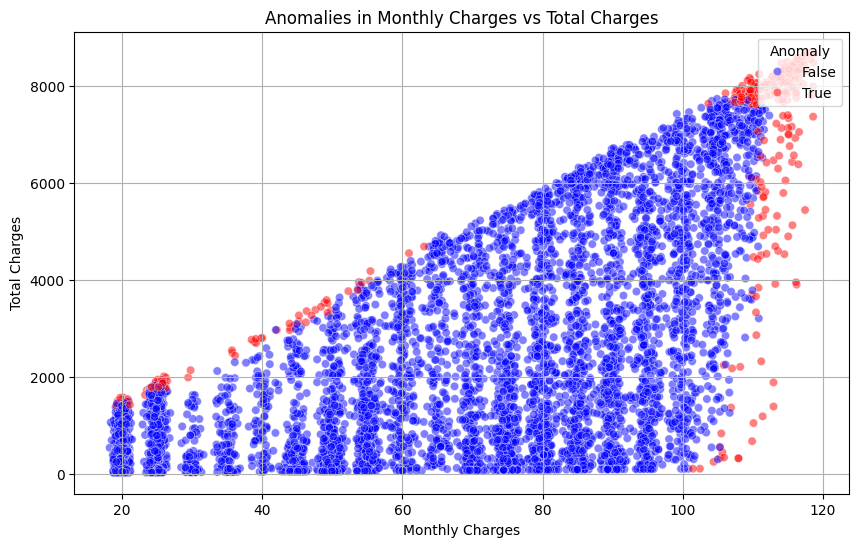

In [23]:
# isolation forest for anomaly detection

numeric_cols = customer.select_dtypes(include=['float64', 'int64']).columns

iso_forest = IsolationForest(contamination=0.05, random_state=42)

iso_forest.fit(customer[numeric_cols])

anomalies = iso_forest.predict(customer[numeric_cols])

customer['Anomaly'] = anomalies == -1

anomaly_count = customer['Anomaly'].sum()
print(f"\nNumber of Outliers: {anomaly_count} ({(anomaly_count/len(customer))*100:.2f}%)")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', hue='Anomaly', data=customer, palette={True: 'red', False: 'blue'}, alpha=0.5)
plt.title('Anomalies in Monthly Charges vs Total Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.legend(title='Anomaly', loc='upper right')
plt.grid()
plt.show()

## Step 2: Feature Engineering

### Feature Engineering

In [55]:
# Create tenure groups 
bins = [0, 12, 48, customer['tenure'].max()+1]  # Shor-term（<1 year）, Mid-term（1-4 years）, Long-term（>4 years）
labels = ['Short-term', 'Mid-term', 'Long-term']
customer['TenureGroup'] = pd.cut(customer['tenure'], bins=bins, labels=labels, right=False)

# Ensure TenureGroup is a categorical variable
customer['TenureGroup'] = customer['TenureGroup'].astype('category')

# check TenureGroup distribution
print("\nTenureGroup Distribution:\n", customer['TenureGroup'].value_counts())


TenureGroup Distribution:
 TenureGroup
Mid-term      2671
Long-term     2303
Short-term    2058
Name: count, dtype: int64


In [56]:
# Calculate average monthly charge, avoid division by zero
customer['AvgMonthlyCharge'] = customer['TotalCharges'] / customer['tenure']
customer['AvgMonthlyCharge'] = customer['TotalCharges'] / customer['tenure']

# Handle inf values (when tenure = 0), replace with MonthlyCharges
customer['AvgMonthlyCharge'] = customer['TotalCharges'] / customer['tenure']
customer['AvgMonthlyCharge'] = customer['AvgMonthlyCharge'].mask(
    (customer['tenure'] == 0) | ~np.isfinite(customer['AvgMonthlyCharge']),
    customer['MonthlyCharges']
)
customer['AvgMonthlyCharge'] = customer['AvgMonthlyCharge'].mask(customer['AvgMonthlyCharge'] == float('inf'), customer['MonthlyCharges'])

# Check the new feature statistics
print("\nNew Feature: AvgMonthlyCharge")
print(customer[['tenure', 'TotalCharges', 'AvgMonthlyCharge']].head(10))


New Feature: AvgMonthlyCharge
   tenure  TotalCharges  AvgMonthlyCharge
0       1         29.85         29.850000
1      34       1889.50         55.573529
2       2        108.15         54.075000
3      45       1840.75         40.905556
4       2        151.65         75.825000
5       8        820.50        102.562500
6      22       1949.40         88.609091
7      10        301.90         30.190000
8      28       3046.05        108.787500
9      62       3487.95         56.257258


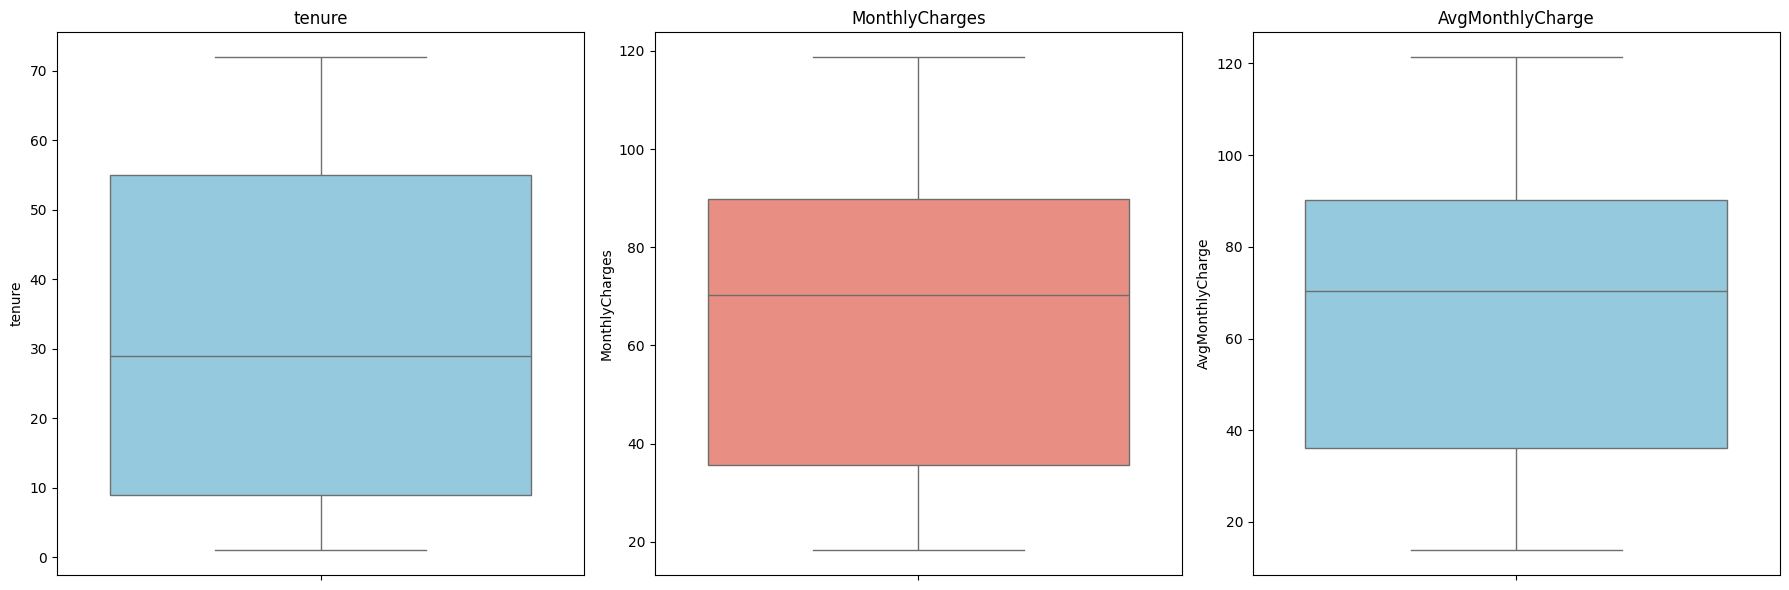

In [57]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = ['skyblue', 'salmon', 'skyblue']
columns = ['tenure', 'MonthlyCharges', 'AvgMonthlyCharge']

for ax, col, color in zip(axes, columns, colors):
    sns.boxplot(y=col, data=customer, ax=ax, color=color)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

Columns in dataframe: ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'SeniorCitizen', 'Anomaly', 'Contract', 'TenureGroup', 'InternetService', 'PaymentMethod', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
Dataframe shape: (7032, 22)


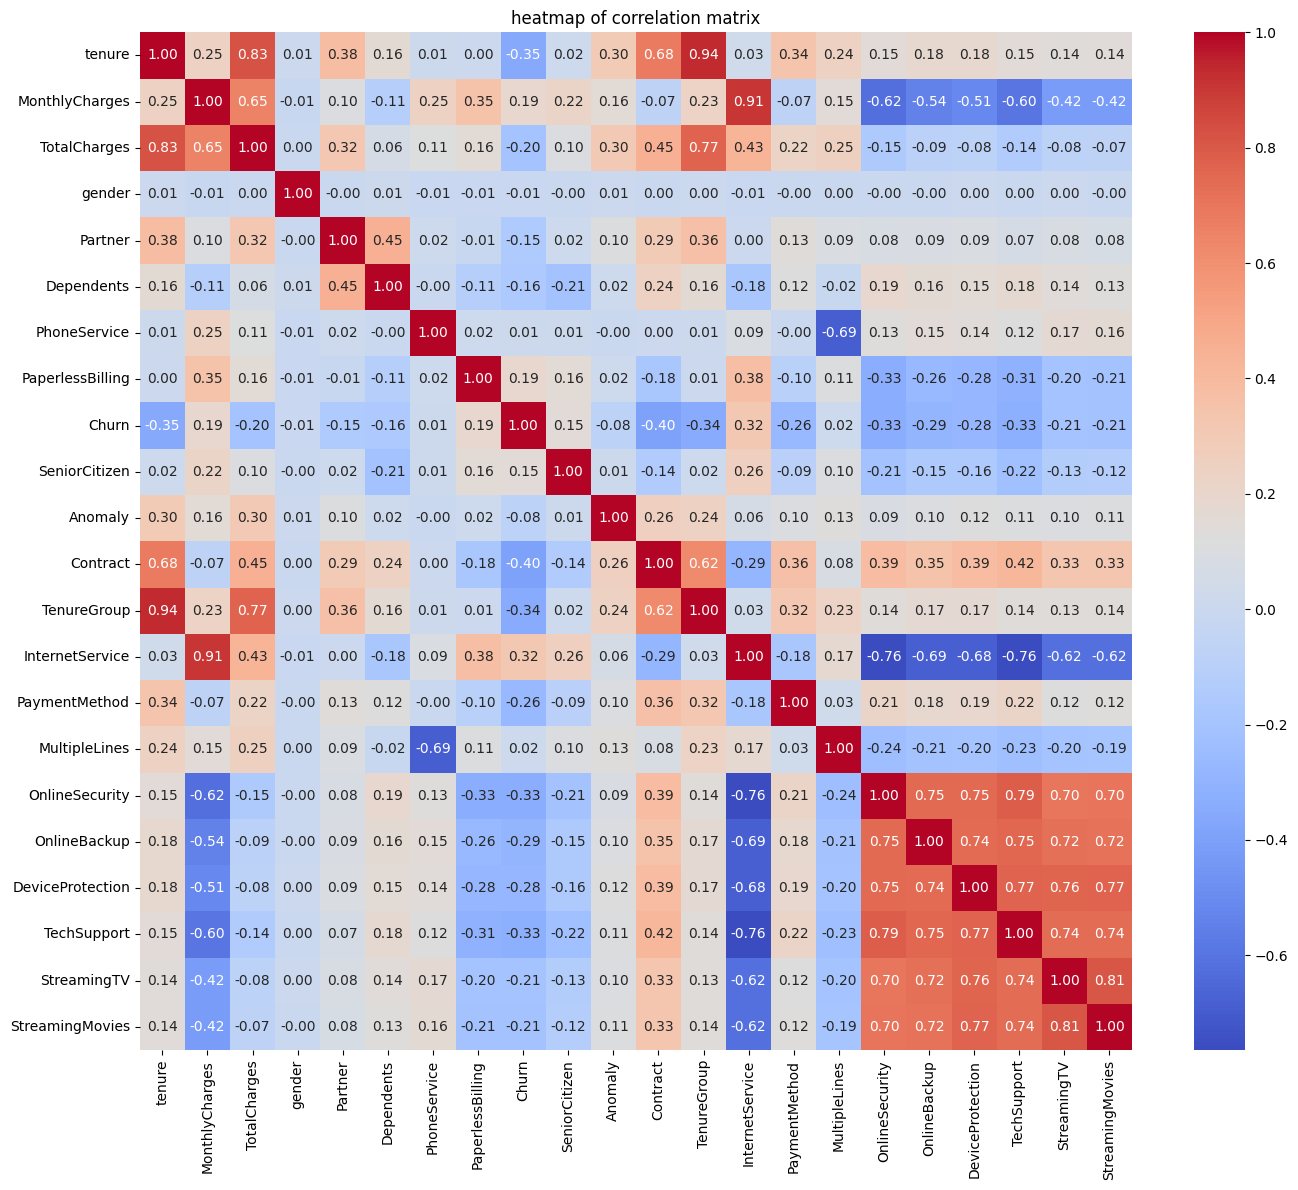


Most related feautres:
Churn               1.000000
InternetService     0.316350
MonthlyCharges      0.192858
PaperlessBilling    0.191454
SeniorCitizen       0.150541
MultipleLines       0.019609
PhoneService        0.011691
gender             -0.008545
Anomaly            -0.079063
Partner            -0.149982
Dependents         -0.163128
TotalCharges       -0.199484
StreamingTV        -0.205246
StreamingMovies    -0.207150
PaymentMethod      -0.262918
DeviceProtection   -0.281048
OnlineBackup       -0.291047
TechSupport        -0.329474
OnlineSecurity     -0.332443
TenureGroup        -0.344579
tenure             -0.354049
Contract           -0.396150
Name: Churn, dtype: float64


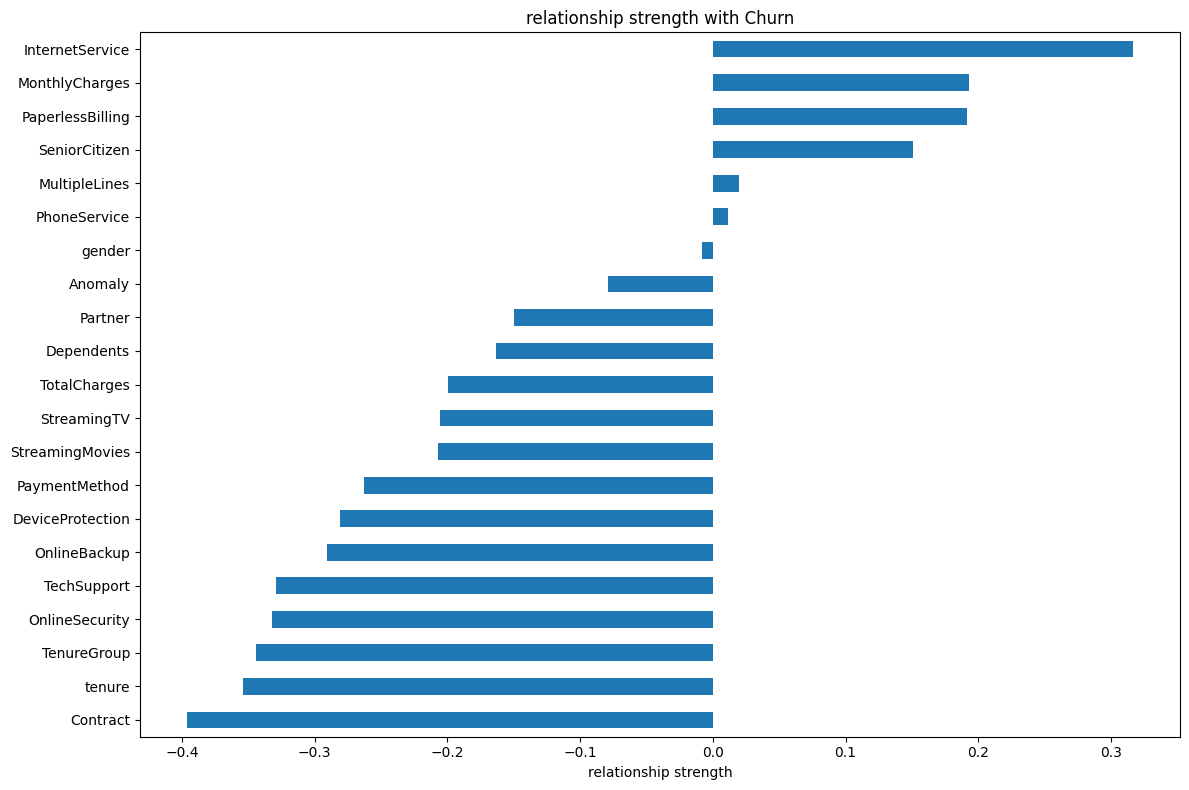

In [58]:
df_clean = pd.DataFrame()

# 1. Copy numeric columns
df_clean['tenure'] = customer['tenure'] 
df_clean['MonthlyCharges'] = customer['MonthlyCharges']
df_clean['TotalCharges'] = pd.to_numeric(customer['TotalCharges'], errors='coerce')

# 2. Explicitly encode main categorical variables
df_clean['gender'] = customer['gender'].map({'Male': 1, 'Female': 0})
df_clean['Partner'] = customer['Partner'].map({'Yes': 1, 'No': 0})
df_clean['Dependents'] = customer['Dependents'].map({'Yes': 1, 'No': 0})
df_clean['PhoneService'] = customer['PhoneService'].map({'Yes': 1, 'No': 0})
df_clean['PaperlessBilling'] = customer['PaperlessBilling'].map({'Yes': 1, 'No': 0})
df_clean['Churn'] = customer['Churn'].map({'Yes': 1, 'No': 0})
df_clean['SeniorCitizen'] = customer['SeniorCitizen']
df_clean['Anomaly'] = customer['Anomaly'].map({True: 1, False: 0})

# 3. Multi-class categorical variables
# Contract type: Month-to-month=0, One year=1, Two year=2
df_clean['Contract'] = customer['Contract'].map({
    'Month-to-month': 0, 
    'One year': 1, 
    'Two year': 2
})

df_clean['TenureGroup'] = customer['TenureGroup'].map({
    'Short-term': 0, 
    'Mid-term': 1, 
    'Long-term': 2
})

# Internet service: No=0, DSL=1, Fiber optic=2
df_clean['InternetService'] = customer['InternetService'].map({
    'No': 0, 
    'DSL': 1, 
    'Fiber optic': 2
})

# Payment method
payment_map = {
    'Electronic check': 0,
    'Mailed check': 1,
    'Bank transfer (automatic)': 2,
    'Credit card (automatic)': 3
}
df_clean['PaymentMethod'] = customer['PaymentMethod'].map(payment_map)

# 4. Add other service features
service_features = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for feature in service_features:
    if 'No internet service' in customer[feature].unique():
        df_clean[feature] = customer[feature].map({
            'No': 0, 
            'Yes': 1, 
            'No internet service': 2,
            'No phone service': 2
        })
    else:
        df_clean[feature] = customer[feature].map({
            'No': 0, 
            'Yes': 1,
            'No phone service': 2
        })

# 5. Check the processed dataframe
print(f"Columns in dataframe: {df_clean.columns.tolist()}")
print(f"Dataframe shape: {df_clean.shape}")

# 6. Calculate the correlation matrix
correlation_matrix = df_clean.corr()

# 7. Plot the full heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('heatmap of correlation matrix')
plt.tight_layout()
plt.show()

# 8. Correlation with Churn
churn_correlation = correlation_matrix['Churn'].sort_values(ascending=False)
print("\nMost related feautres:")
print(churn_correlation)

# 9. Plot correlation bar chart
plt.figure(figsize=(12, 8))
churn_correlation.drop('Churn').sort_values().plot(kind='barh')
plt.title('relationship strength with Churn')
plt.xlabel('relationship strength')
plt.tight_layout()
plt.show()

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\4170004366.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


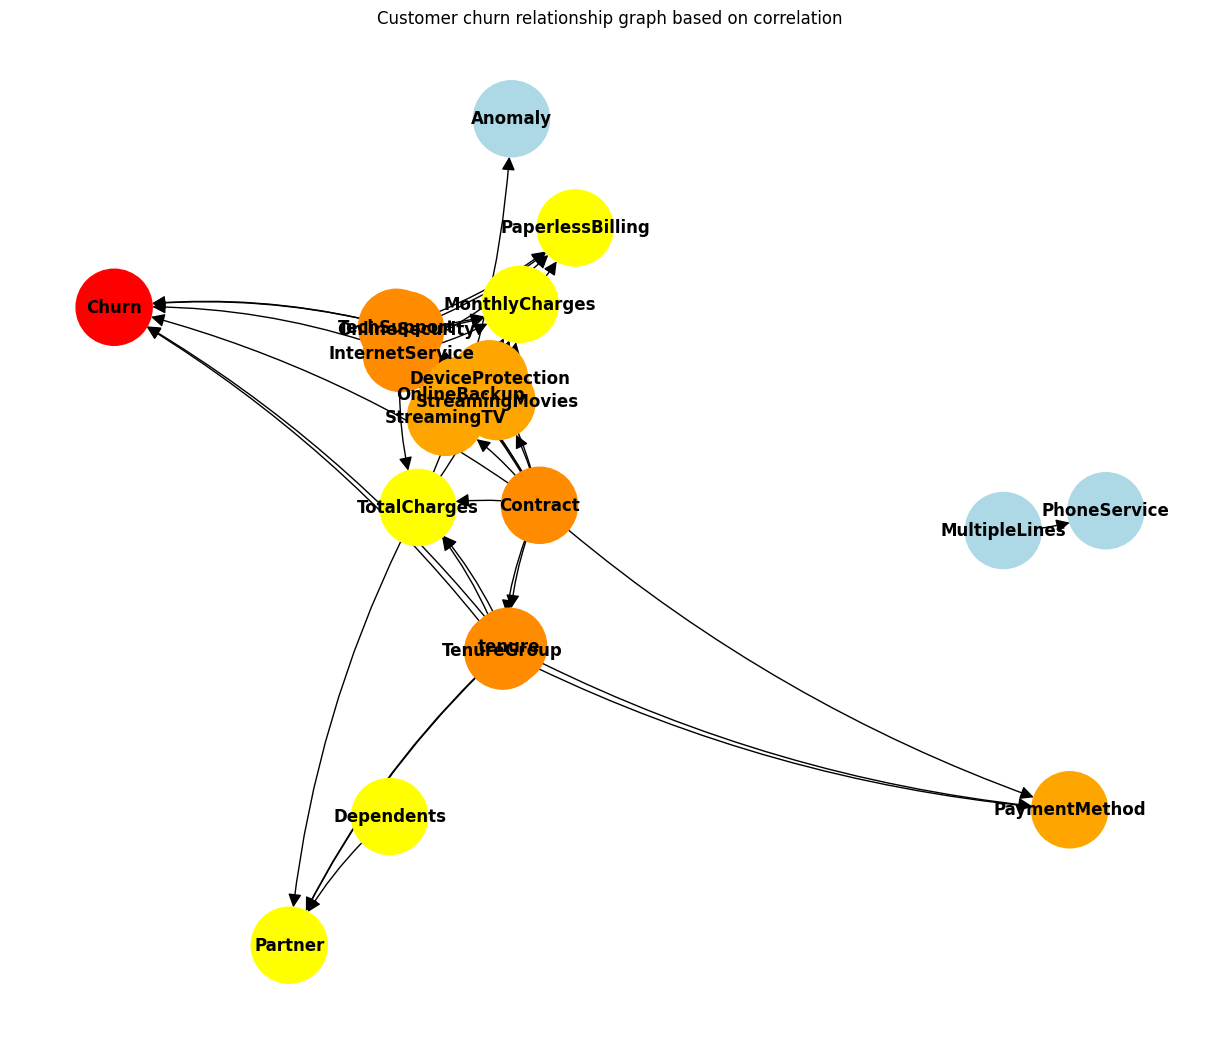

Directly pointing to Churn's features: ['tenure', 'Contract', 'TenureGroup', 'InternetService', 'OnlineSecurity', 'TechSupport']


In [59]:
# 1. Use correlation threshold to build the graph
correlation_matrix = df_clean.corr().abs()

# 2. Set correlation threshold, only keep strongly correlated edges
threshold = 0.3 
edges = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        col_i = correlation_matrix.columns[i]
        col_j = correlation_matrix.columns[j]
        if correlation_matrix.iloc[i, j] > threshold:
            if col_j == 'Churn':
                edges.append((col_i, col_j))
            elif col_i == 'Churn':
                edges.append((col_j, col_i))
            elif correlation_matrix.loc[col_i, 'Churn'] > correlation_matrix.loc[col_j, 'Churn']:
                edges.append((col_i, col_j))
            else:
                edges.append((col_j, col_i))

# 3. Create NetworkX graph object
G = nx.DiGraph()
G.add_edges_from(edges)

# 4. Plot the directed graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42) 

# Use correlation with Churn to determine node color
node_colors = []
for node in G.nodes():
    if node == 'Churn':
        node_colors.append('red') 
    else:
        corr_with_churn = abs(correlation_matrix.loc[node, 'Churn'])
        if corr_with_churn > 0.3:
            node_colors.append('darkorange')
        elif corr_with_churn > 0.2:
            node_colors.append('orange')
        elif corr_with_churn > 0.1:
            node_colors.append('yellow')
        else:
            node_colors.append('lightblue')

nx.draw(G, pos, with_labels=True, node_color=node_colors, 
        node_size=3000, font_size=12, font_weight='bold',
        arrowsize=20, connectionstyle='arc3,rad=0.1')
plt.title("Customer churn relationship graph based on correlation")
plt.tight_layout()
plt.show()

# 5. Identify features that directly point to Churn
direct_causes = list(G.predecessors('Churn'))
print(f"Directly pointing to Churn's features: {direct_causes}")

In [35]:

correlation_matrix = df_clean.corr().abs()
threshold = 0.4 

edges = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        col_i = correlation_matrix.columns[i]
        col_j = correlation_matrix.columns[j]
        if correlation_matrix.iloc[i, j] > threshold:
            if col_j == 'Churn':
                edges.append((col_i, col_j))
            elif col_i == 'Churn':
                edges.append((col_j, col_i))
            elif correlation_matrix.loc[col_i, 'Churn'] > correlation_matrix.loc[col_j, 'Churn']:
                edges.append((col_i, col_j))
            else:
                edges.append((col_j, col_i))

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\165463908.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


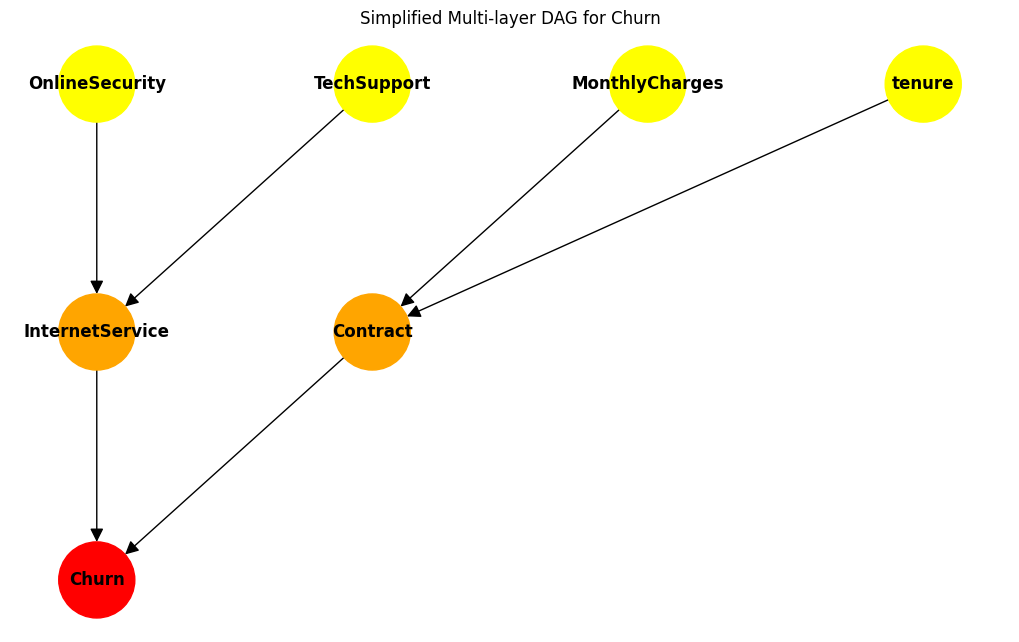

In [36]:
# Manually select or construct simplified multistep edges
edges = [
    ('OnlineSecurity', 'InternetService'),
    ('TechSupport', 'InternetService'),
    ('InternetService', 'Churn'),
    ('Contract', 'Churn'),
    ('tenure', 'Contract'),
    ('MonthlyCharges', 'Contract')
]

G = nx.DiGraph()
G.add_edges_from(edges)

# Define manual layout by layer
layer1 = ['OnlineSecurity', 'TechSupport', 'MonthlyCharges', 'tenure']
layer2 = ['InternetService', 'Contract']
layer3 = ['Churn']

pos = {}
# x-spacing
x_spacing = 1.0 / (max(len(layer1), len(layer2), len(layer3)) + 1)

for i, node in enumerate(layer1):
    pos[node] = (x_spacing * (i+1), 2)
for i, node in enumerate(layer2):
    pos[node] = (x_spacing * (i+1), 1)
for i, node in enumerate(layer3):
    pos[node] = (x_spacing * (i+1), 0)

# Colors
node_colors = []
for node in G.nodes:
    if node == 'Churn':
        node_colors.append('red')
    elif node in layer2:
        node_colors.append('orange')
    else:
        node_colors.append('yellow')

# Draw
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color=node_colors,
        node_size=3000, font_size=12, font_weight='bold',
        arrowsize=20)
plt.title("Simplified Multi-layer DAG for Churn")
plt.tight_layout()
plt.show()

Correlation between Contract_X_tenure and Churn: -0.34493911926531046
Correlation between MonthlyCharges_X_tenure and Churn: -0.19967529725205035


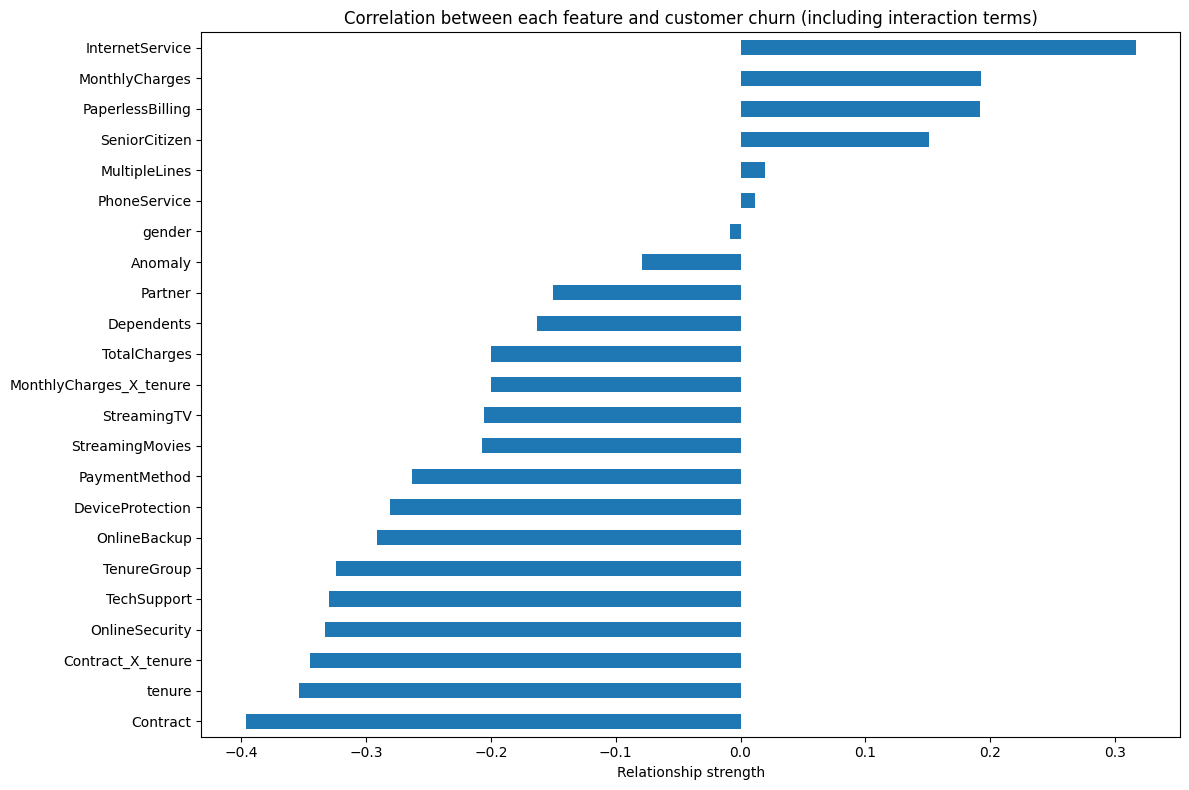

In [ ]:
# Ensure 'Contract' is mapped to integers
df_clean['Contract'] = customer['Contract'].map({
    'Month-to-month': 0, 
    'One year': 1, 
    'Two year': 2
}).astype(int)  

# Create interaction terms
df_clean['Contract_X_tenure'] = df_clean['Contract'] * df_clean['tenure']
df_clean['MonthlyCharges_X_tenure'] = df_clean['MonthlyCharges'] * df_clean['tenure']

# Check the correlation of the newly created interaction terms with Churn
print("Correlation between Contract_X_tenure and Churn:", df_clean['Contract_X_tenure'].corr(df_clean['Churn']))
print("Correlation between MonthlyCharges_X_tenure and Churn:", df_clean['MonthlyCharges_X_tenure'].corr(df_clean['Churn']))

# Plot correlation bar chart including interaction terms
plt.figure(figsize=(12, 8))
df_corr = df_clean.corr()['Churn'].sort_values()
df_corr.drop('Churn').plot(kind='barh')
plt.title('Correlation between each feature and customer churn (including interaction terms)')
plt.xlabel('Relationship strength')
plt.tight_layout()
plt.show()

## Step 3: Predictive Modeling & Customer Segmentation Analysis

### Predictive Modeling

#### Baseline: Logistic Regression

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'C': 1}
Best cross-validation score: 0.8468

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1300
           1       0.62      0.50      0.55       458

    accuracy                           0.79      1758
   macro avg       0.73      0.70      0.71      1758
weighted avg       0.78      0.79      0.78      1758

ROC AUC: 0.8330

Feature Importance:
             Feature  Coefficient  Abs_Coefficient
11   InternetService     0.883970         0.883970
0             tenure    -0.674064         0.674064
9           Contract    -0.615091         0.615091
19   StreamingMovies     0.300480         0.300480
14    OnlineSecurity    -0.296676         0.296676
18       StreamingTV     0.260780         0.260780
17       TechSupport    -0.250050         0.250050
1     MonthlyCharges    -0.183759         0.183759
13     MultipleLines     0.1793

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2088431010.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=feature_importance.values, y=feature_importance.index, palette=colors)


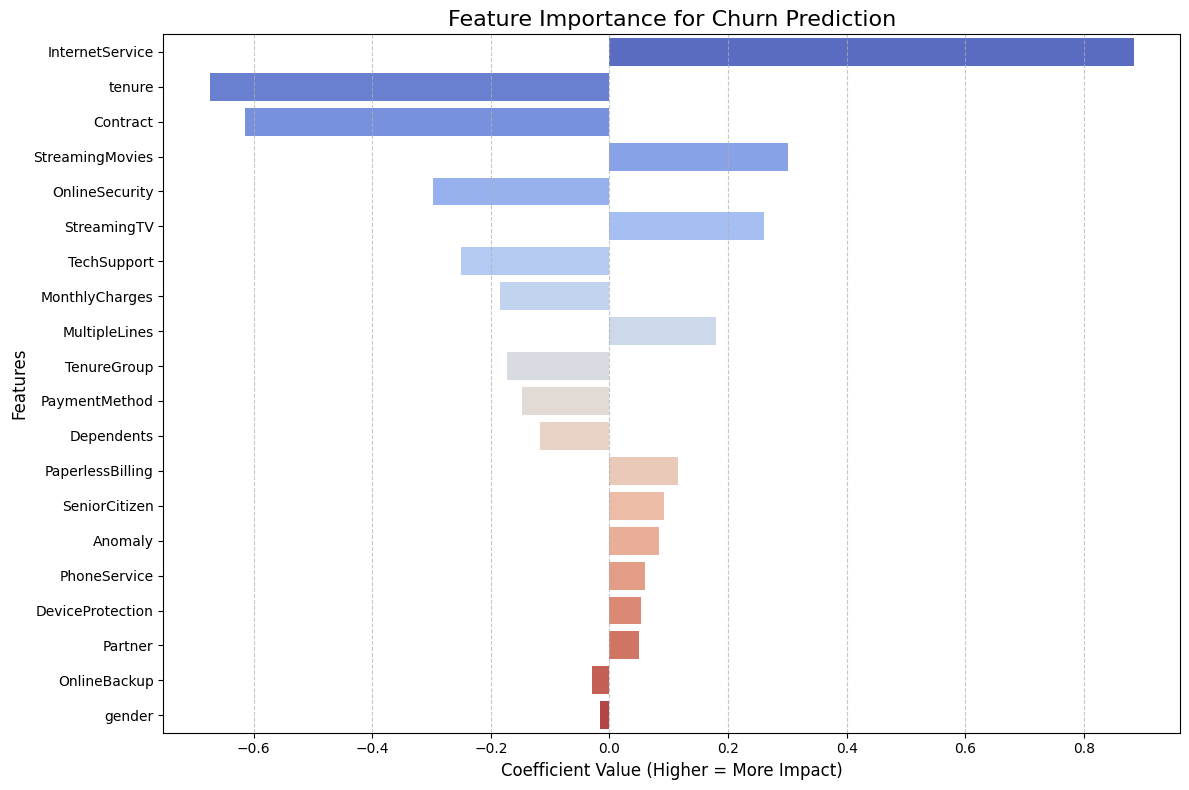

In [ ]:
df_clean = df_clean.drop('TotalCharges', axis=1)
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with L1 regularization
log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=0.5, random_state=42)

# Use grid search to find the best regularization strength
param_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10]}
grid_search = GridSearchCV(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the model with the best parameters
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train_scaled, y_train)

# Evaluate on the test set
y_pred = best_log_reg.predict(X_test_scaled)
y_pred_proba = best_log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# View feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_log_reg.coef_[0],
    'Abs_Coefficient': np.abs(best_log_reg.coef_[0])
})

feature_importance_df = feature_importance_df.sort_values('Abs_Coefficient', ascending=False)
print("\nFeature Importance:")
print(feature_importance_df)

feature_importance = pd.Series(best_log_reg.coef_[0], index=X_train.columns)
feature_importance = feature_importance.reindex(feature_importance.abs().sort_values(ascending=False).index)

n_features = len(feature_importance)
colors = sns.color_palette("coolwarm", n_features)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=feature_importance.values, y=feature_importance.index, palette=colors)

plt.title("Feature Importance for Churn Prediction", fontsize=16)
plt.xlabel("Coefficient Value (Higher = More Impact)", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

y_pred_proba_original = best_log_reg.predict_proba(X_test_scaled)[:, 1]

#### Oversampling + Undersampling

In [62]:
# Re-split the training and test sets (keep the test set untouched for resampling)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Apply SMOTE + Tomek Links on the training set
smt = SMOTETomek(random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_temp, y_temp)

# Standardization
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Output the number of samples per class after resampling
print("Class distribution in training set (after resampling):\n", pd.Series(y_resampled).value_counts())

# Fill NaN values in X_resampled after SMOTETomek using mean imputation
imputer = SimpleImputer(strategy='mean')
X_resampled_imputed = imputer.fit_transform(X_resampled)
X_test_imputed = imputer.transform(X_test)

# Standardize features
X_train_scaled = scaler.fit_transform(X_resampled_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

Class distribution in training set (after resampling):
 Churn
0    3775
1    3775
Name: count, dtype: int64


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'C': 10}
Best cross-validation score: 0.8705

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1300
           1       0.51      0.76      0.61       458

    accuracy                           0.75      1758
   macro avg       0.70      0.75      0.71      1758
weighted avg       0.80      0.75      0.76      1758

ROC AUC: 0.8285


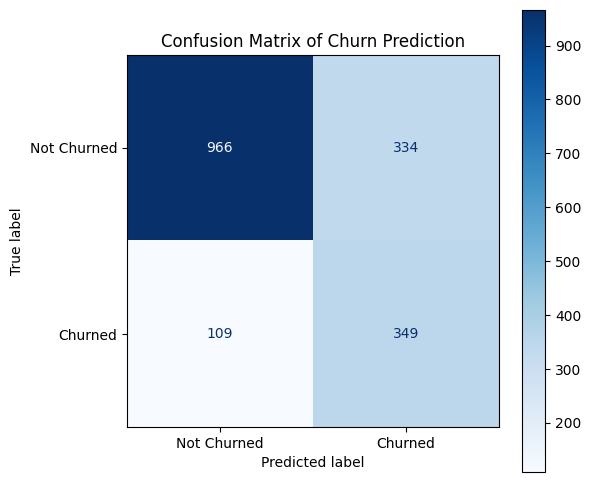

In [63]:
grid_search.fit(X_train_scaled, y_resampled)

# Print best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the model with the best parameters
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train_scaled, y_resampled)

# Evaluate on the test set
y_pred = best_log_reg.predict(X_test_scaled)
y_pred_proba = best_log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
labels = ['Not Churned', 'Churned']
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix of Churn Prediction')
plt.grid(False)
plt.show()

y_pred_proba_smote = best_log_reg.predict_proba(X_test_scaled)[:, 1]

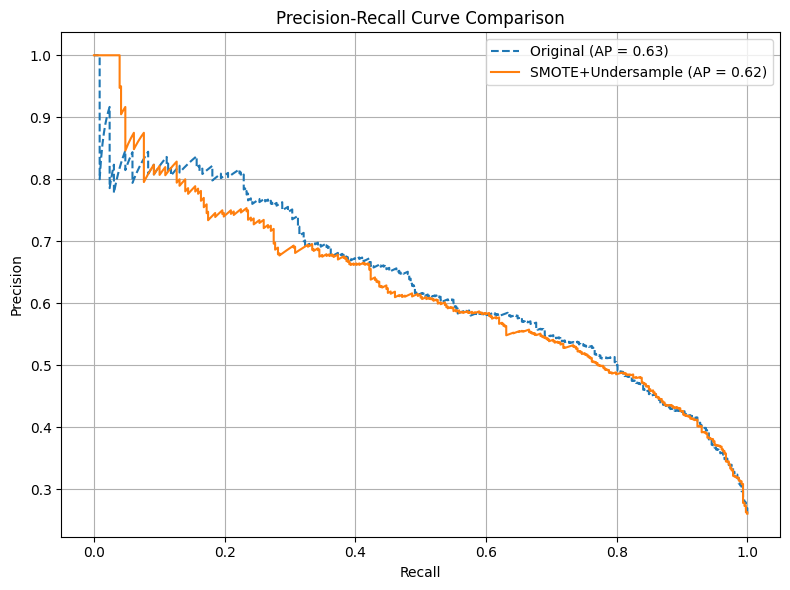

In [64]:
# Original Model
precision_orig, recall_orig, _ = precision_recall_curve(y_test, y_pred_proba_original)
ap_orig = average_precision_score(y_test, y_pred_proba_original)

# SMOTE
precision_smote, recall_smote, _ = precision_recall_curve(y_test, y_pred_proba_smote)
ap_smote = average_precision_score(y_test, y_pred_proba_smote)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall_orig, precision_orig, label=f'Original (AP = {ap_orig:.2f})', linestyle='--')
plt.plot(recall_smote, precision_smote, label=f'SMOTE+Undersample (AP = {ap_smote:.2f})', linestyle='-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Decision Tree

d:\software\anaconda\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'max_depth': 5, 'min_samples_split': 5}
Best CV ROC AUC: 0.8308

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1300
           1       0.59      0.56      0.57       458

    accuracy                           0.78      1758
   macro avg       0.72      0.71      0.71      1758
weighted avg       0.78      0.78      0.78      1758

ROC AUC: 0.8223


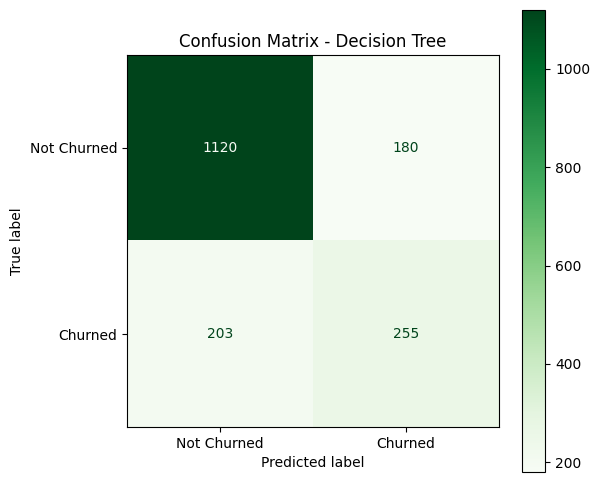

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\3670493000.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')


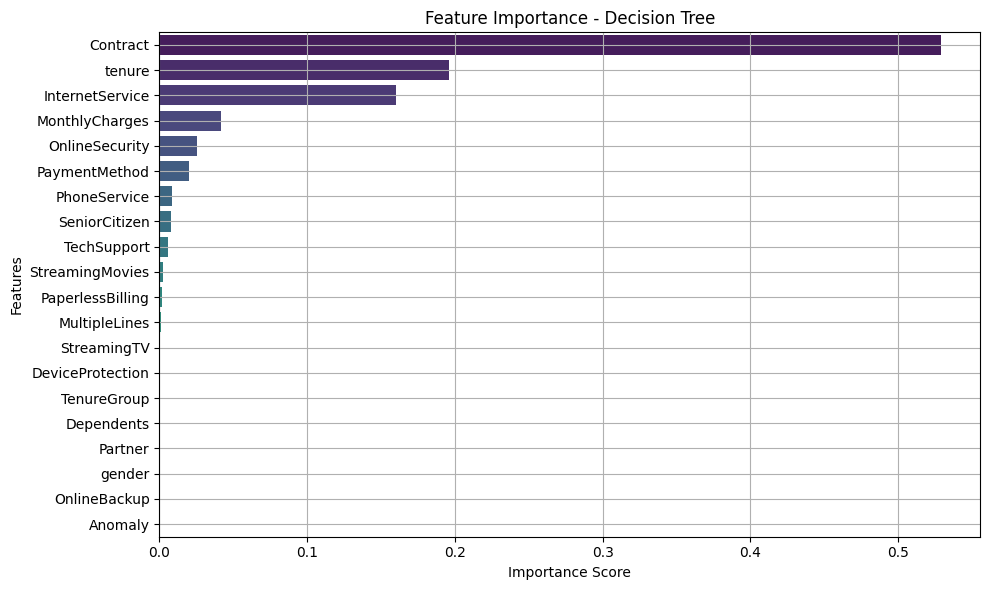

In [65]:
# === 1. Impute + Scale ===
X_resampled_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_imputed)

# === 2. Decision Tree + Grid Search ===
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

tree_clf = DecisionTreeClassifier(random_state=42)
grid_search_tree = GridSearchCV(tree_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search_tree.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_search_tree.best_params_}")
print(f"Best CV ROC AUC: {grid_search_tree.best_score_:.4f}")

# === 3. Best Model Evaluation ===
best_tree = grid_search_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test_scaled)
y_pred_proba_tree = best_tree.predict_proba(X_test_scaled)[:, 1]

print("\nDecision Tree - Classification Report:")
print(classification_report(y_test, y_pred_tree))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_tree):.4f}")

# === 4. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_tree)
labels = ['Not Churned', 'Churned']
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens', ax=ax, values_format='d')
plt.title('Confusion Matrix - Decision Tree')
plt.grid(False)
plt.show()

# === 5. Feature Importance Plot ===
feature_names = X.columns
importances = best_tree.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')
plt.title('Feature Importance - Decision Tree')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True)
plt.tight_layout()
plt.show()


In [66]:
# save
joblib.dump(best_tree, 'decision_tree_model.pkl')
print("Model has been saved as decision_tree_model.pkl")

Model has been saved as decision_tree_model.pkl


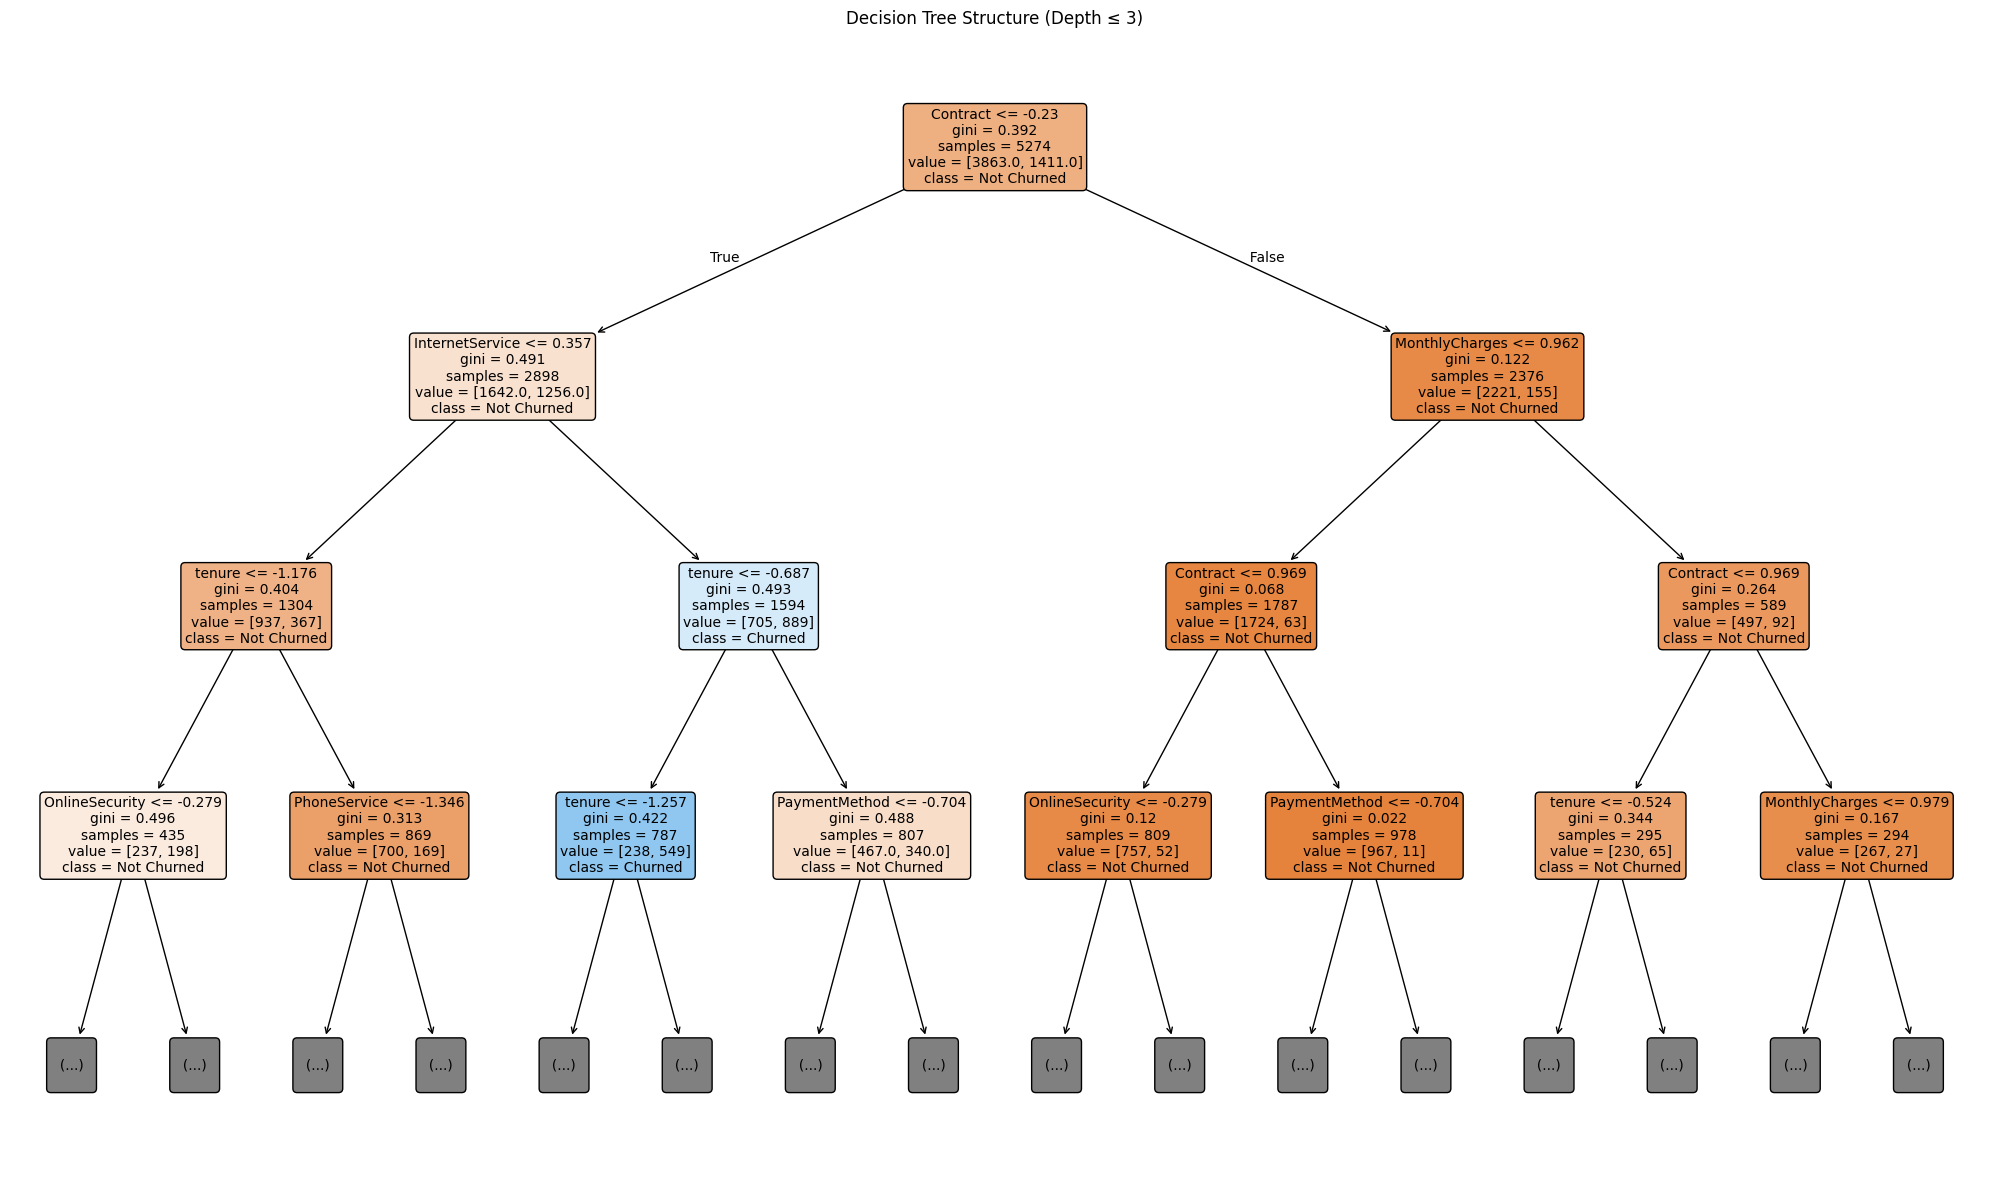

In [67]:
feature_names = X.columns 
class_names = ['Not Churned', 'Churned']

plt.figure(figsize=(20, 12))
plot_tree(
    best_tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=10,
    proportion=False,
    max_depth=3 
)
plt.title("Decision Tree Structure (Depth ≤ 3)")
plt.tight_layout()
plt.show()

### Random Forest

In [71]:
X_train, y_train = X_temp, y_temp

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best CV ROC AUC: 0.8487

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1300
           1       0.65      0.42      0.51       458

    accuracy                           0.79      1758
   macro avg       0.74      0.67      0.69      1758
weighted avg       0.78      0.79      0.77      1758

ROC AUC: 0.8310


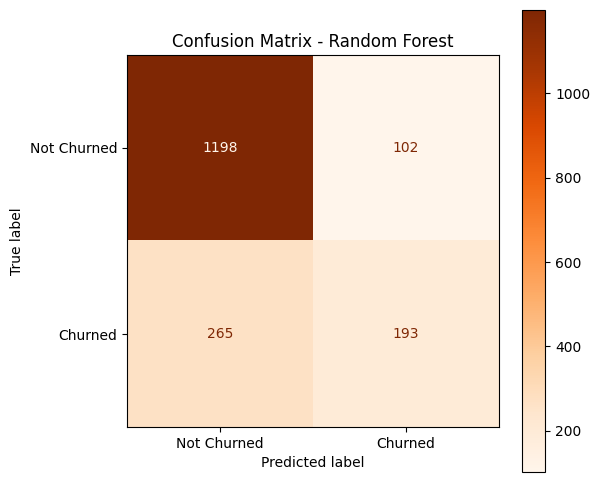

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\537219622.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='mako')


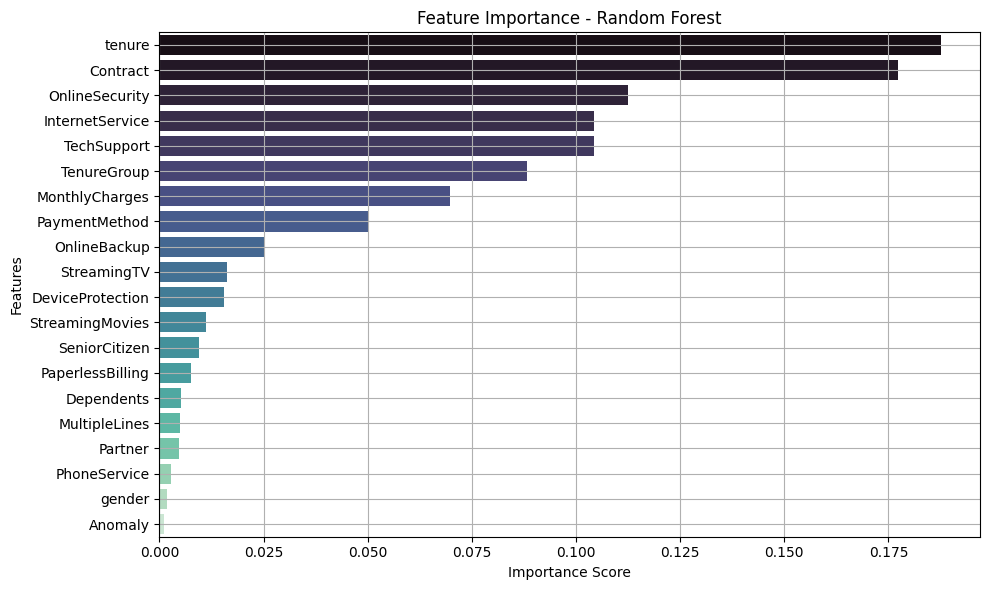

In [68]:
# === 1. Impute + Scale (using original training set X_temp, y_temp) ===
X_train_imputed = imputer.fit_transform(X_temp)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# === 2. Define Random Forest and parameter grid ===
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# === 3. Grid search for hyperparameter tuning ===
grid_search_rf.fit(X_train_scaled, y_temp)

# === 4. Output best parameters and validation score ===
print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Best CV ROC AUC: {grid_search_rf.best_score_:.4f}")

# === 5. Use the best model to predict the test set ===
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

# === 6. Output performance metrics ===
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# === 7. Confusion Matrix Visualization ===
cm = confusion_matrix(y_test, y_pred_rf)
labels = ['Not Churned', 'Churned']
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Oranges', ax=ax, values_format='d')
plt.title('Confusion Matrix - Random Forest')
plt.grid(False)
plt.show()

# === 8. Feature Importance Visualization ===
feature_names = X.columns 
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='mako')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True)
plt.tight_layout()
plt.show()


In [69]:
# save
joblib.dump(best_rf, 'random_forest_model.pkl')
print("Random Forest model has been saved as 'random_forest_model.pkl'")

Random Forest model has been saved as 'random_forest_model.pkl'


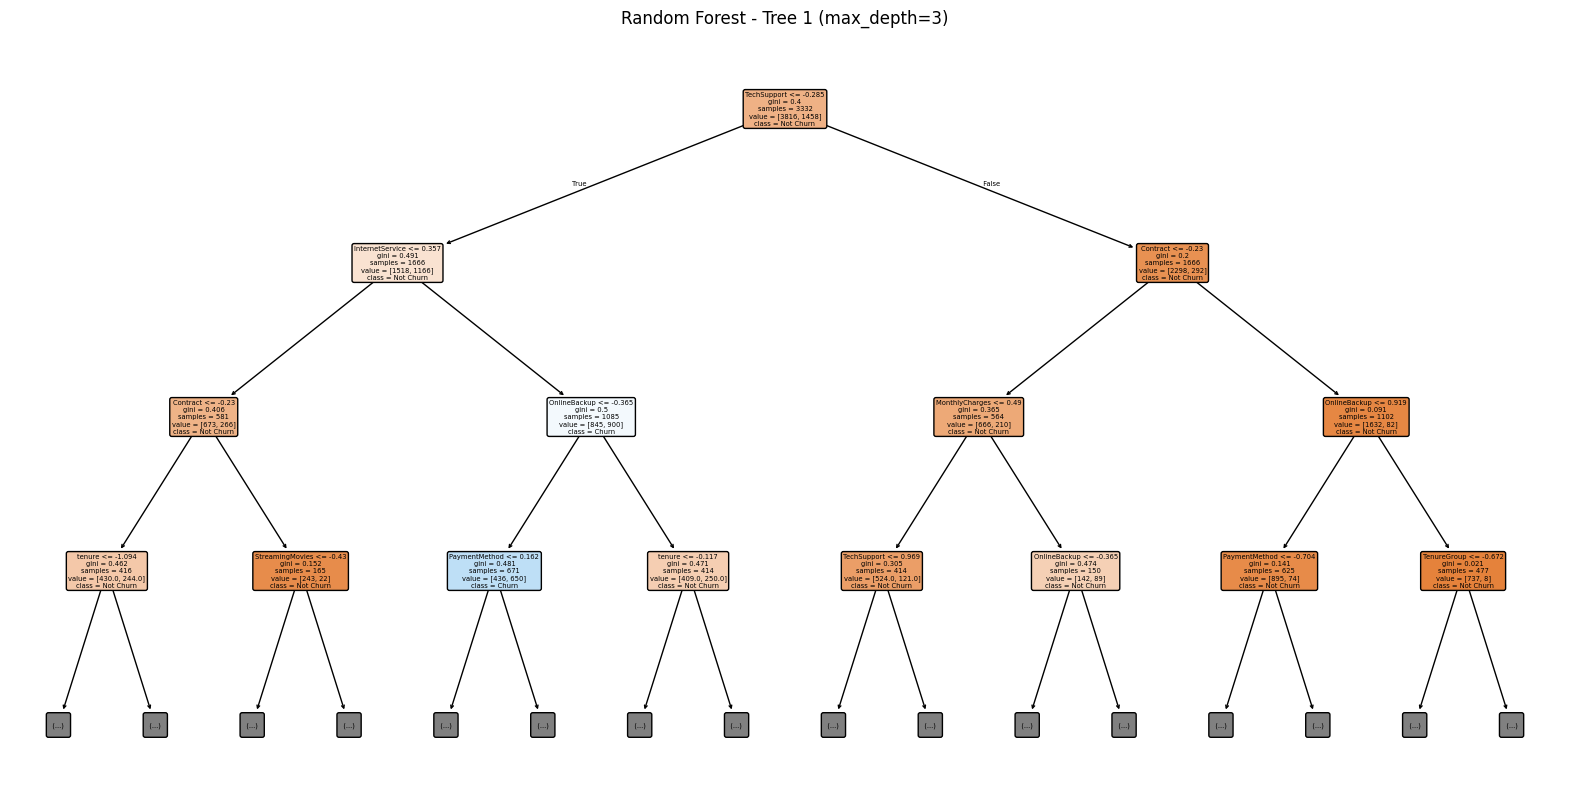

In [70]:
# Plot the first tree in the Random Forest
plt.figure(figsize=(20, 10))
plot_tree(best_rf.estimators_[0], 
          feature_names=X.columns, 
          class_names=['Not Churn', 'Churn'], 
          filled=True, rounded=True, max_depth=3) 
plt.title("Random Forest - Tree 1 (max_depth=3)")
plt.show()

### XGBoost

d:\software\anaconda\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits


d:\software\anaconda\envs\ml\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:38:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV ROC AUC: 0.8519

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.86      1300
           1       0.63      0.50      0.56       458

    accuracy                           0.79      1758
   macro avg       0.73      0.70      0.71      1758
weighted avg       0.78      0.79      0.78      1758

ROC AUC: 0.8353


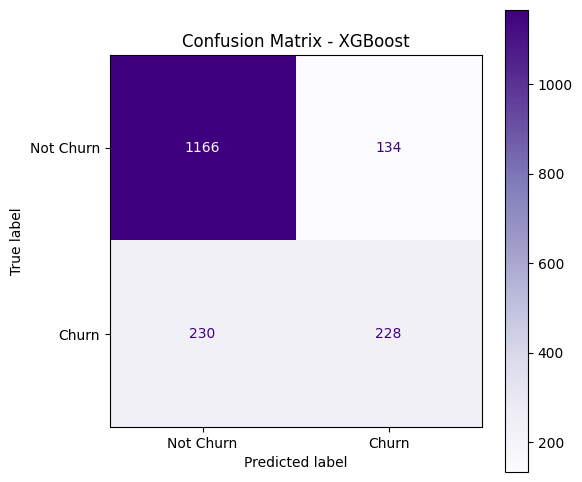

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2191359412.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='rocket')


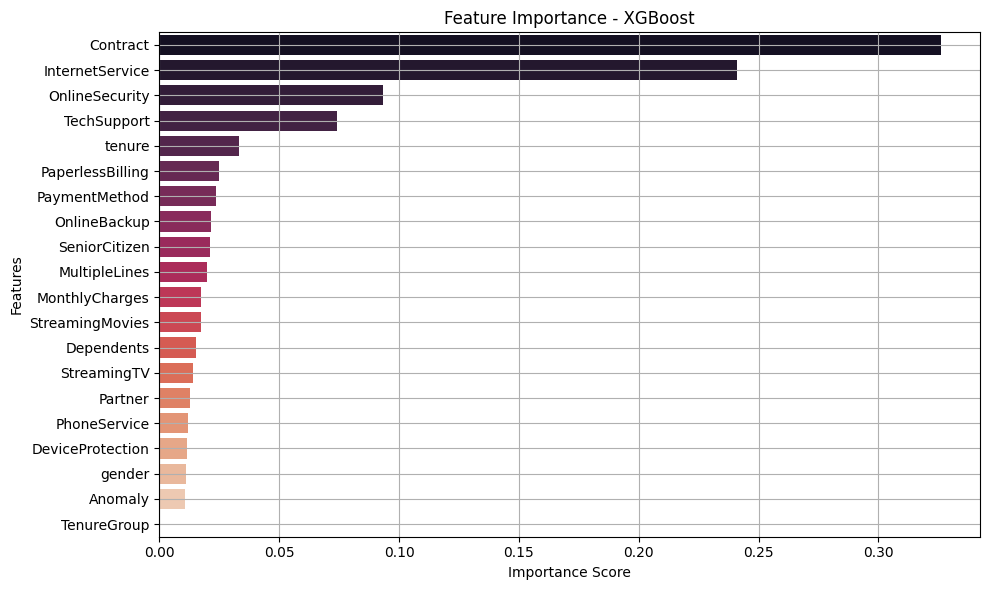

In [72]:
# === 1. Impute missing values and standardize features using the original data ===
X_train_imputed = imputer.fit_transform(X_temp)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test)

# === 2. XGBoost model definition and parameter search ===
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X_train_scaled, y_temp)

# === 3. Print best results ===
print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"Best CV ROC AUC: {grid_search_xgb.best_score_:.4f}")

# === 4. Test set evaluation ===
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_pred_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

print("\nXGBoost - Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

# === 5. Confusion Matrix Visualization ===
cm = confusion_matrix(y_test, y_pred_xgb)
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churn', 'Churn'])
disp.plot(cmap='Purples', ax=ax, values_format='d')
plt.title('Confusion Matrix - XGBoost')
plt.grid(False)
plt.show()

# === 6. Feature Importance Visualization ===
importances = best_xgb.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='rocket')
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
joblib.dump(best_xgb, 'xgboost_model.pkl')

['xgboost_model.pkl']

### Comparison

In [74]:
# Save the logistic regression model trained on original data
joblib.dump(best_log_reg, "best_logreg_original_data.pkl")
# Save the logistic regression model trained on SMOTE + undersampled data
joblib.dump(best_log_reg, "best_logreg_smote_data.pkl")

['best_logreg_smote_data.pkl']

In [75]:
# Load models
log_reg_original = joblib.load("best_logreg_original_data.pkl")
log_reg_smote = joblib.load("best_logreg_smote_data.pkl")
dt_model = joblib.load("decision_tree_model.pkl")    
rf_model = joblib.load("random_forest_model.pkl")
xgb_model = joblib.load("xgboost_model.pkl")

# Get prediction probabilities for each model on the test set
y_pred_proba_log_original = log_reg_original.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_log_smote = log_reg_smote.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

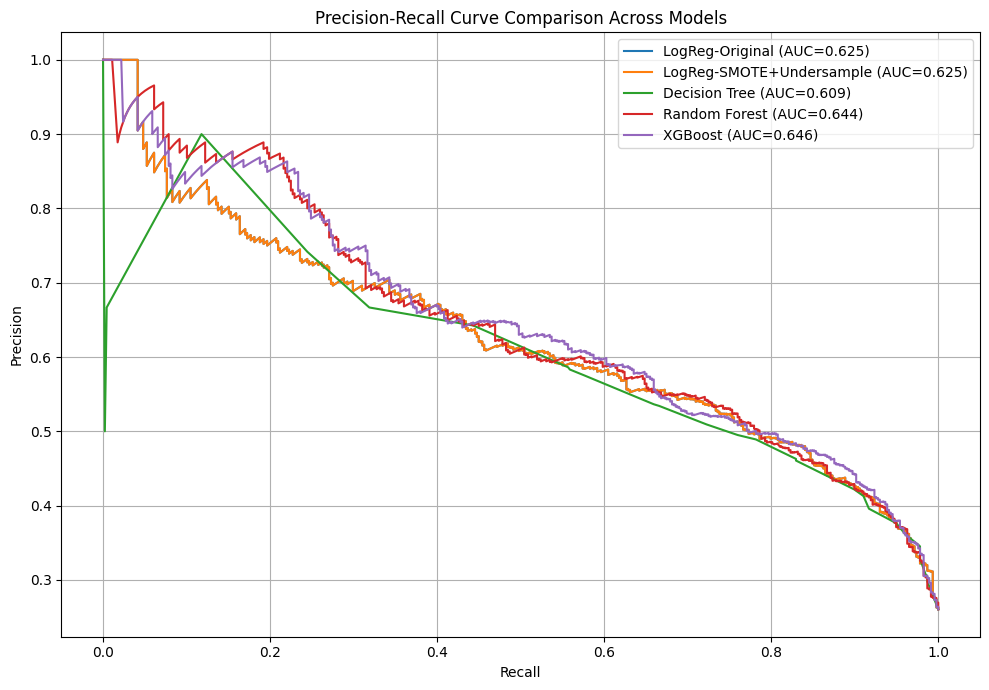

In [76]:
# ✅ Precision-Recall Curve
plt.figure(figsize=(10, 7))

def plot_pr(model_name, y_proba):
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (AUC={pr_auc:.3f})')

# ✅ Plot
plot_pr("LogReg-Original", y_pred_proba_log_original)
plot_pr("LogReg-SMOTE+Undersample", y_pred_proba_log_smote)
plot_pr("Decision Tree", y_pred_proba_dt)
plot_pr("Random Forest", y_pred_proba_rf)
plot_pr("XGBoost", y_pred_proba_xgb)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison Across Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


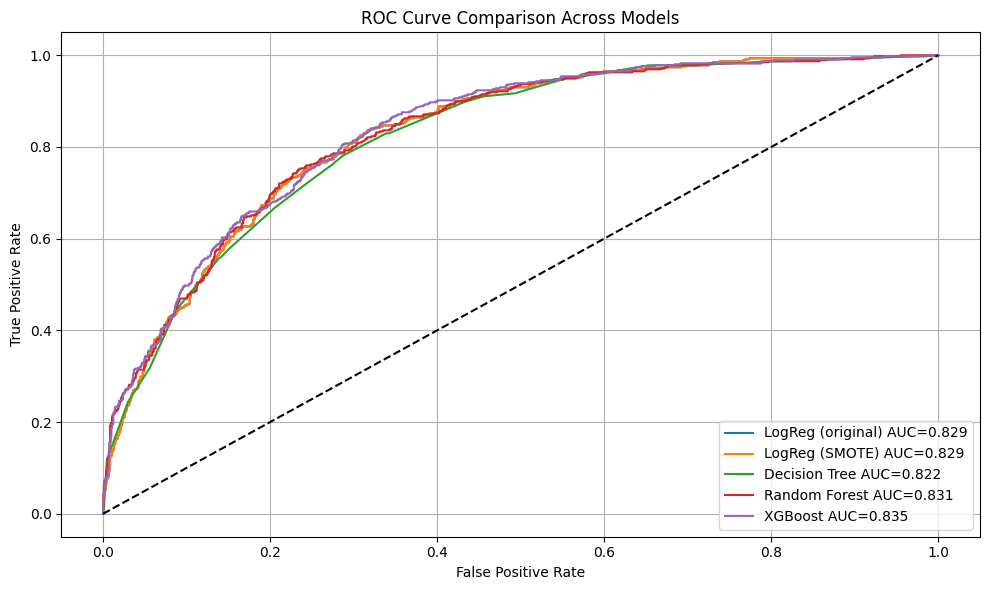

In [79]:
# Calculate ROC curves and AUC values
fpr_log_o, tpr_log_o, _ = roc_curve(y_test, y_pred_proba_log_original)
fpr_log_s, tpr_log_s, _ = roc_curve(y_test, y_pred_proba_log_smote)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_proba_tree)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

auc_log_o = auc(fpr_log_o, tpr_log_o)
auc_log_s = auc(fpr_log_s, tpr_log_s)
auc_tree = auc(fpr_tree, tpr_tree)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_log_o, tpr_log_o, label=f'LogReg (original) AUC={auc_log_o:.3f}')
plt.plot(fpr_log_s, tpr_log_s, label=f'LogReg (SMOTE) AUC={auc_log_s:.3f}')
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree AUC={auc_tree:.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest AUC={auc_rf:.3f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost AUC={auc_xgb:.3f}')

plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison Across Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [80]:
## Comparison Table of Model Performance

y_true = y_test  

models_proba = {
    'LogReg_Original': y_pred_proba_log_original,
    'LogReg_SMOTE': y_pred_proba_log_smote,
    'DecisionTree': y_pred_proba_dt,
    'RandomForest': y_pred_proba_rf,
    'XGBoost': y_pred_proba_xgb
}

threshold = 0.5

results = []

for model_name, y_proba in models_proba.items():
    y_pred = (y_proba >= threshold).astype(int)
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    auc_pr = average_precision_score(y_true, y_proba)
    
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'AUC-ROC': auc_roc,
        'AUC-PR': auc_pr
    })

results_df = pd.DataFrame(results)
results_df = results_df.round(4)  

print("Model Comparison Table")
display(results_df)

Model Comparison Table


,Model,Accuracy,Precision,Recall,F1-score,AUC-ROC,AUC-PR
0,LogReg_Original,0.6809,0.4425,0.8646,0.5854,0.8293,0.6255
1,LogReg_SMOTE,0.6809,0.4425,0.8646,0.5854,0.8293,0.6255
2,DecisionTree,0.7810,0.5831,0.5590,0.5708,0.8223,0.5992
3,RandomForest,0.7912,0.6542,0.4214,0.5126,0.8310,0.6440
4,XGBoost,0.7929,0.6298,0.4978,0.5561,0.8353,0.6469


### Customer Segmentation Analysis

### SHAP

In [81]:
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
best_xgb = joblib.load("xgboost_model.pkl") 
explainer = shap.Explainer(best_xgb, X_test_scaled)
shap_values = explainer(X_test_scaled)

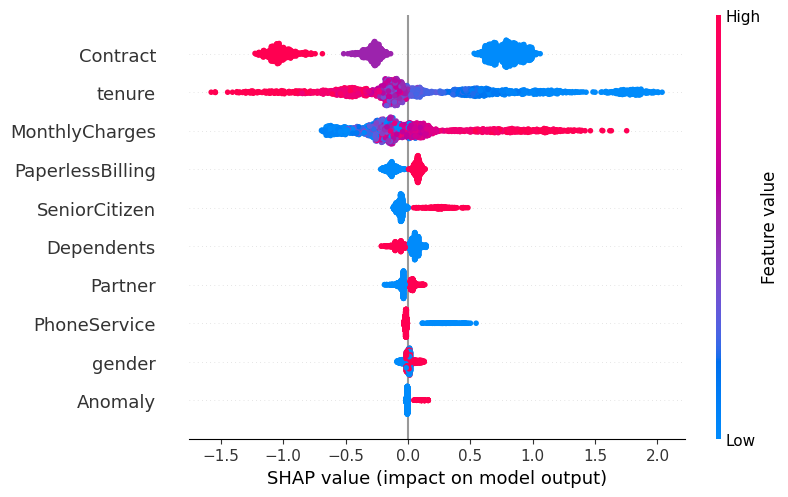

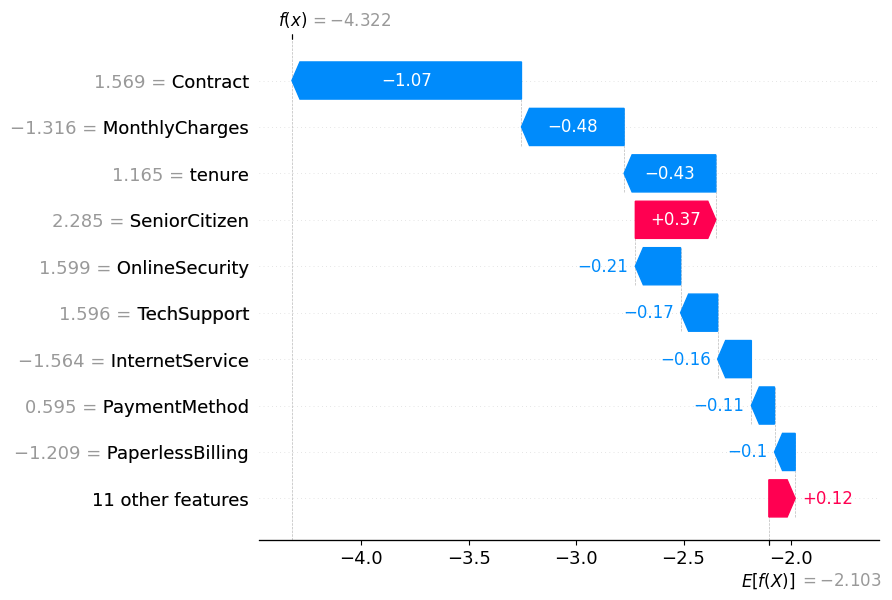

In [82]:
# Wrap test data with column names
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Create explainer and calculate SHAP values
explainer = shap.Explainer(best_xgb, X_test_df)
shap_values = explainer(X_test_df)

# Beeswarm plot (global top 10 features)
shap.plots.beeswarm(shap_values[:, :10], max_display=10)

# Waterfall plot (explain the first user)
sample_ind = 0
shap.plots.waterfall(shap_values[sample_ind], max_display=10)

## Other Visualizations

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2217388404.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contract_churn = df_clean.groupby('Contract')['Churn'].mean() * 100
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2217388404.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=contract_churn_df.index, y=contract_churn_df['Churn_Rate'], palette=palette_custom)


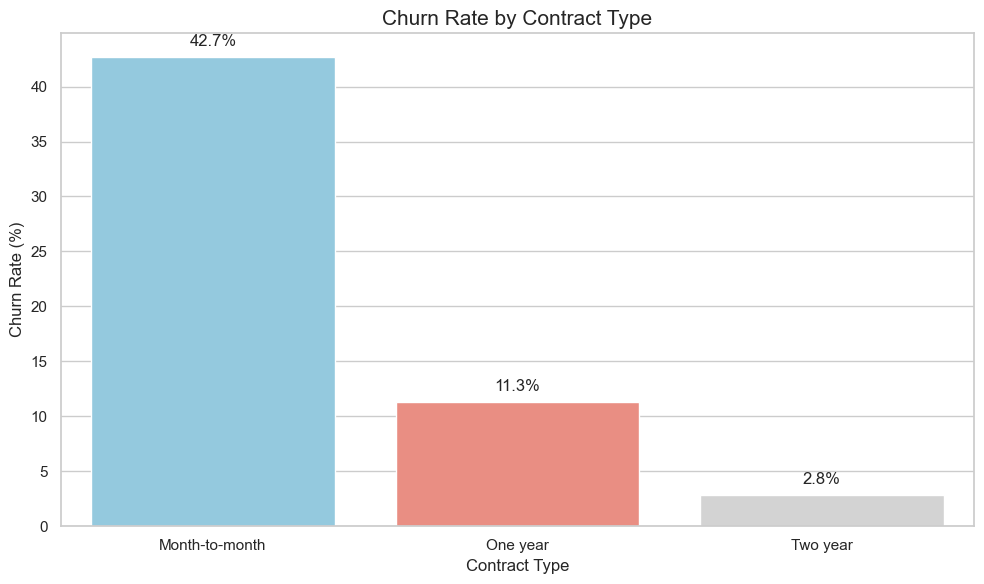

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2217388404.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  security_churn = df_clean.groupby('OnlineSecurity')['Churn'].mean() * 100
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2217388404.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=security_churn_df.index, y=security_churn_df['Churn_Rate'], palette=palette_custom)


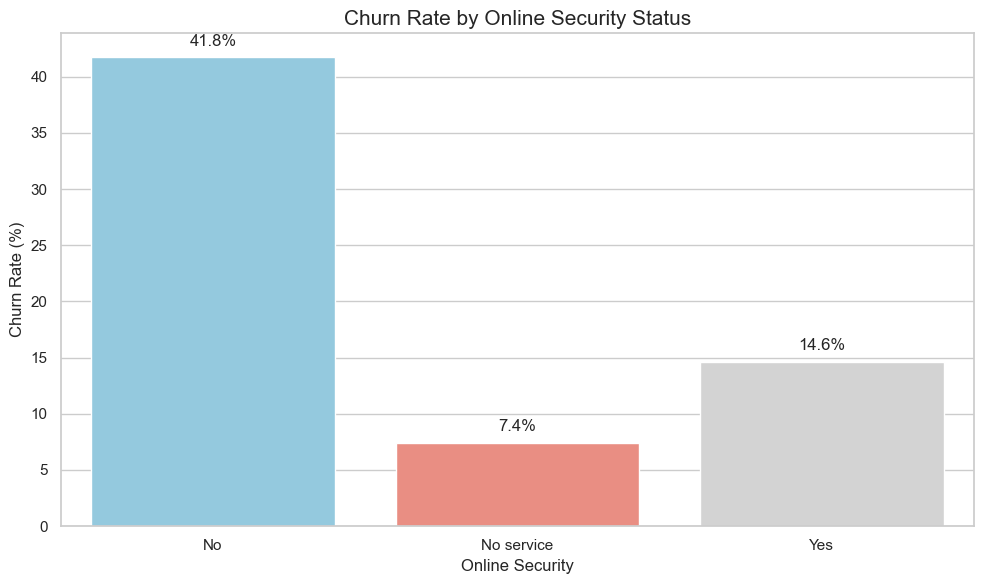

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2217388404.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tech_churn = df_clean.groupby('TechSupport')['Churn'].mean() * 100
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2217388404.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tech_churn_df.index, y=tech_churn_df['Churn_Rate'], palette=palette_custom)


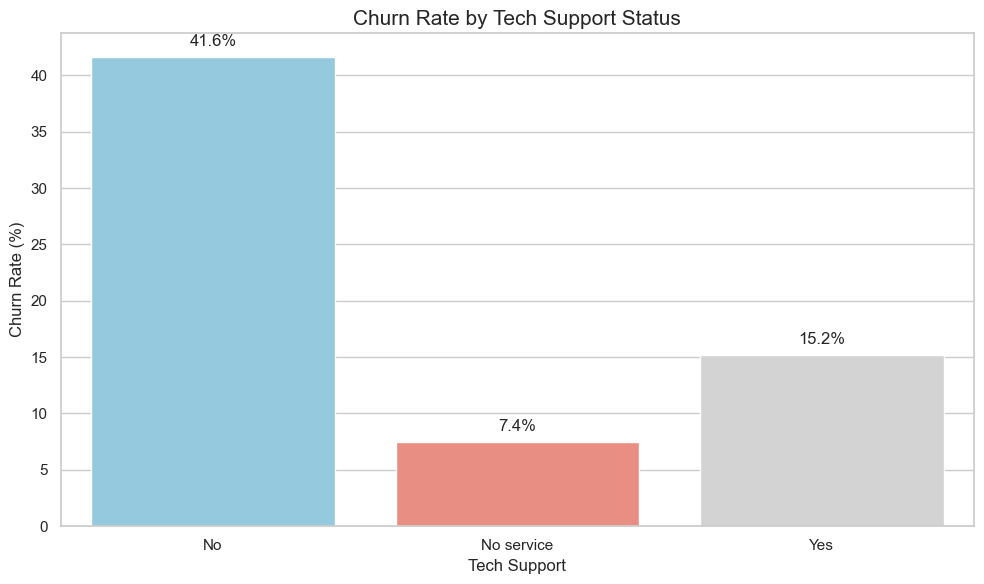

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2217388404.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  internet_churn = df_clean.groupby('InternetService')['Churn'].mean() * 100
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2217388404.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=internet_churn_df.index, y=internet_churn_df['Churn_Rate'], palette=palette_custom)


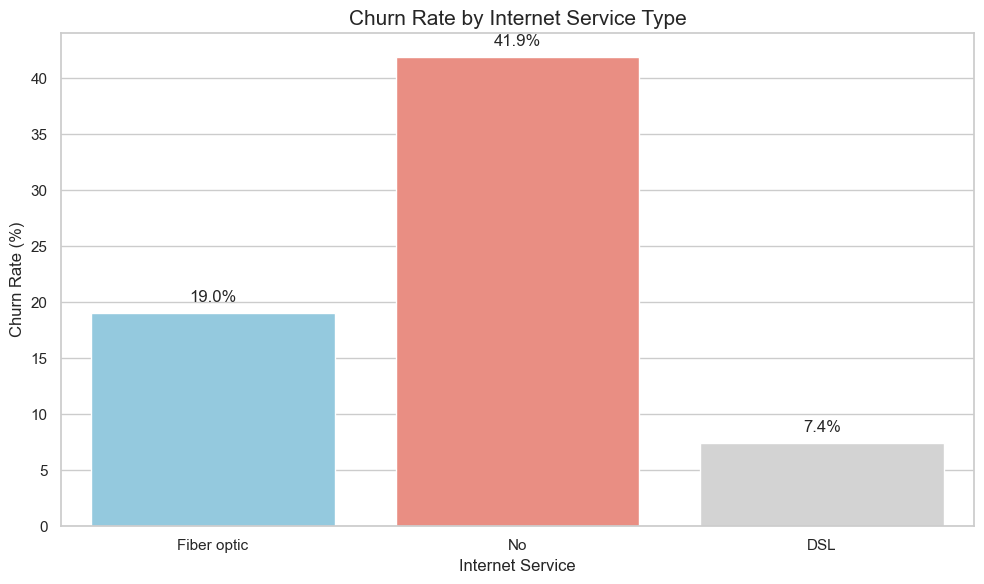

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2217388404.py:90: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = df_clean.pivot_table(


<Figure size 1400x800 with 0 Axes>

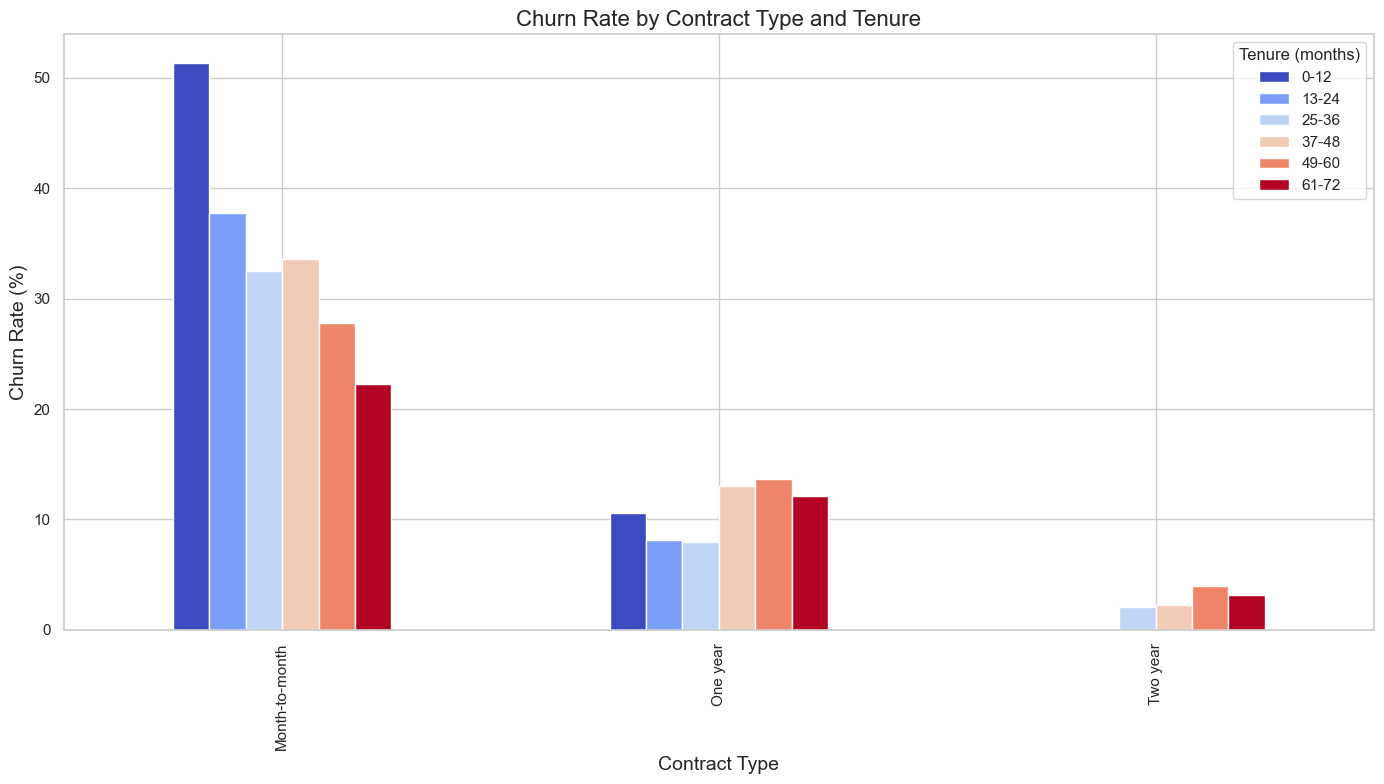

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2217388404.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contract_churn_df.index, y=contract_churn_df['Churn_Rate'], ax=axs[0, 0], palette=palette_custom)
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2217388404.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=internet_churn_df.index, y=internet_churn_df['Churn_Rate'], ax=axs[1, 0], palette=palette_custom)
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\2217388404.py:151: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current beh

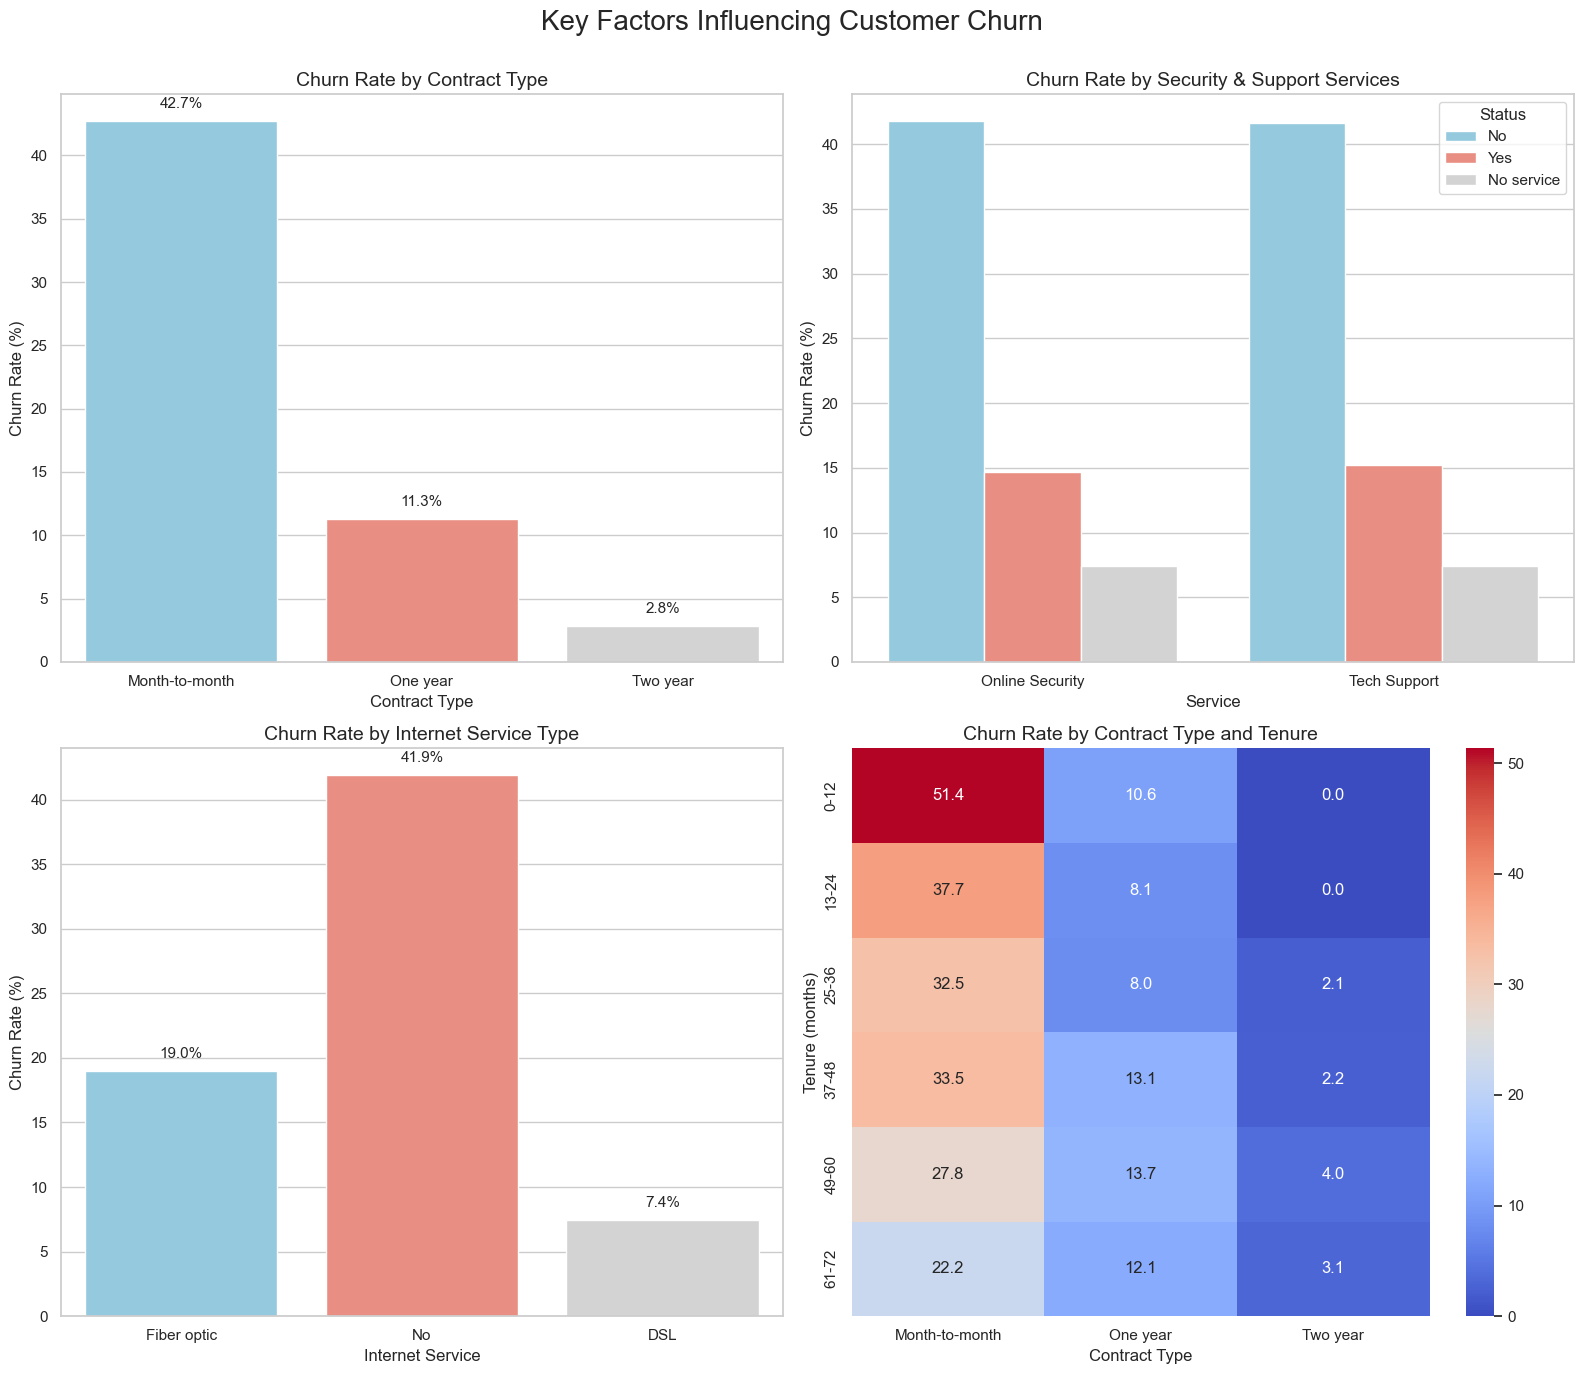

In [83]:
sns.set_theme(style="whitegrid")
palette_custom = ['skyblue', 'salmon', 'lightgray'] 

df_clean['Churn'] = pd.to_numeric(df_clean['Churn'])

contract_labels = {0: 'Month-to-month', 1: 'One year', 2: 'Two year'}
service_labels = {0: 'No', 1: 'Yes', 2: 'No service'}
internet_labels = {0: 'DSL', 1: 'Fiber optic', 2: 'No'}

### 1. Contract Type vs Churn Rate ###
plt.figure(figsize=(10, 6))
contract_churn = df_clean.groupby('Contract')['Churn'].mean() * 100
contract_churn_df = pd.DataFrame({'Churn_Rate': contract_churn})
contract_churn_df.index = [contract_labels.get(x, x) for x in contract_churn_df.index]

ax = sns.barplot(x=contract_churn_df.index, y=contract_churn_df['Churn_Rate'], palette=palette_custom)
plt.title('Churn Rate by Contract Type', fontsize=15)
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

for i, v in enumerate(contract_churn_df['Churn_Rate']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('contract_churn.png', dpi=300, bbox_inches='tight')
plt.show()

### 2. Online Security vs Churn Rate ###
plt.figure(figsize=(10, 6))
security_churn = df_clean.groupby('OnlineSecurity')['Churn'].mean() * 100
security_churn_df = pd.DataFrame({'Churn_Rate': security_churn})
security_churn_df.index = [service_labels.get(x, x) for x in security_churn_df.index]

ax = sns.barplot(x=security_churn_df.index, y=security_churn_df['Churn_Rate'], palette=palette_custom)
plt.title('Churn Rate by Online Security Status', fontsize=15)
plt.xlabel('Online Security', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

for i, v in enumerate(security_churn_df['Churn_Rate']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('security_churn.png', dpi=300, bbox_inches='tight')
plt.show()

### 3. Tech Support vs Churn Rate ###
plt.figure(figsize=(10, 6))
tech_churn = df_clean.groupby('TechSupport')['Churn'].mean() * 100
tech_churn_df = pd.DataFrame({'Churn_Rate': tech_churn})
tech_churn_df.index = [service_labels.get(x, x) for x in tech_churn_df.index]

ax = sns.barplot(x=tech_churn_df.index, y=tech_churn_df['Churn_Rate'], palette=palette_custom)
plt.title('Churn Rate by Tech Support Status', fontsize=15)
plt.xlabel('Tech Support', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

for i, v in enumerate(tech_churn_df['Churn_Rate']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('techsupport_churn.png', dpi=300, bbox_inches='tight')
plt.show()

### 4. Internet Service vs Churn Rate ###
plt.figure(figsize=(10, 6))
internet_churn = df_clean.groupby('InternetService')['Churn'].mean() * 100
internet_churn_df = pd.DataFrame({'Churn_Rate': internet_churn})
internet_churn_df.index = [internet_labels.get(x, x) for x in internet_churn_df.index]

ax = sns.barplot(x=internet_churn_df.index, y=internet_churn_df['Churn_Rate'], palette=palette_custom)
plt.title('Churn Rate by Internet Service Type', fontsize=15)
plt.xlabel('Internet Service', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

for i, v in enumerate(internet_churn_df['Churn_Rate']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('internet_churn.png', dpi=300, bbox_inches='tight')
plt.show()

### 5. Contract*Tenure ###
df_clean['Tenure_Group'] = pd.cut(
    df_clean['tenure'], 
    bins=[0, 12, 24, 36, 48, 60, 72], 
    labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'],
    include_lowest=True
)

pivot_data = df_clean.pivot_table(
    index='Contract',
    columns='Tenure_Group',
    values='Churn',
    aggfunc='mean'
) * 100
pivot_data.index = [contract_labels.get(x, x) for x in pivot_data.index]

plt.figure(figsize=(14, 8))
ax = pivot_data.plot(kind='bar', figsize=(14, 8), colormap='coolwarm')
plt.title('Churn Rate by Contract Type and Tenure', fontsize=16)
plt.xlabel('Contract Type', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.legend(title='Tenure (months)')

plt.tight_layout()
plt.savefig('contract_tenure_churn.png', dpi=300, bbox_inches='tight')
plt.show()

### 6. Combined Visualization ###
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Key Factors Influencing Customer Churn', fontsize=20, y=0.98)

# Contract Type
sns.barplot(x=contract_churn_df.index, y=contract_churn_df['Churn_Rate'], ax=axs[0, 0], palette=palette_custom)
axs[0, 0].set_title('Churn Rate by Contract Type', fontsize=14)
axs[0, 0].set_xlabel('Contract Type', fontsize=12)
axs[0, 0].set_ylabel('Churn Rate (%)', fontsize=12)
for i, v in enumerate(contract_churn_df['Churn_Rate']):
    axs[0, 0].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=11)

# Online Security & Tech Support Combined
security_data = pd.DataFrame({
    'Service': 'Online Security',
    'Status': [service_labels.get(x, x) for x in df_clean['OnlineSecurity'].unique()],
    'Churn_Rate': [df_clean[df_clean['OnlineSecurity'] == x]['Churn'].mean() * 100 
                   for x in df_clean['OnlineSecurity'].unique()]
})

tech_data = pd.DataFrame({
    'Service': 'Tech Support',
    'Status': [service_labels.get(x, x) for x in df_clean['TechSupport'].unique()],
    'Churn_Rate': [df_clean[df_clean['TechSupport'] == x]['Churn'].mean() * 100 
                   for x in df_clean['TechSupport'].unique()]
})

combined_df = pd.concat([security_data, tech_data])
sns.barplot(x='Service', y='Churn_Rate', hue='Status', data=combined_df, ax=axs[0, 1], palette=palette_custom)
axs[0, 1].set_title('Churn Rate by Security & Support Services', fontsize=14)
axs[0, 1].set_ylabel('Churn Rate (%)', fontsize=12)
axs[0, 1].legend(title='Status')

# Internet Service
sns.barplot(x=internet_churn_df.index, y=internet_churn_df['Churn_Rate'], ax=axs[1, 0], palette=palette_custom)
axs[1, 0].set_title('Churn Rate by Internet Service Type', fontsize=14)
axs[1, 0].set_xlabel('Internet Service', fontsize=12)
axs[1, 0].set_ylabel('Churn Rate (%)', fontsize=12)
for i, v in enumerate(internet_churn_df['Churn_Rate']):
    axs[1, 0].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=11)

# Heatmap for Contract × Tenure
pivot_tenure_contract = pd.pivot_table(
    df_clean,
    values='Churn',
    index='Tenure_Group',
    columns='Contract',
    aggfunc='mean'
) * 100
pivot_tenure_contract.columns = [contract_labels.get(x, x) for x in pivot_tenure_contract.columns]

sns.heatmap(pivot_tenure_contract, annot=True, fmt='.1f', cmap='coolwarm', ax=axs[1, 1])
axs[1, 1].set_title('Churn Rate by Contract Type and Tenure', fontsize=14)
axs[1, 1].set_xlabel('Contract Type', fontsize=12)
axs[1, 1].set_ylabel('Tenure (months)', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('churn_factors_combined.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\299161082.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contract_churn = df_clean.groupby('Contract')['Churn'].mean() * 100


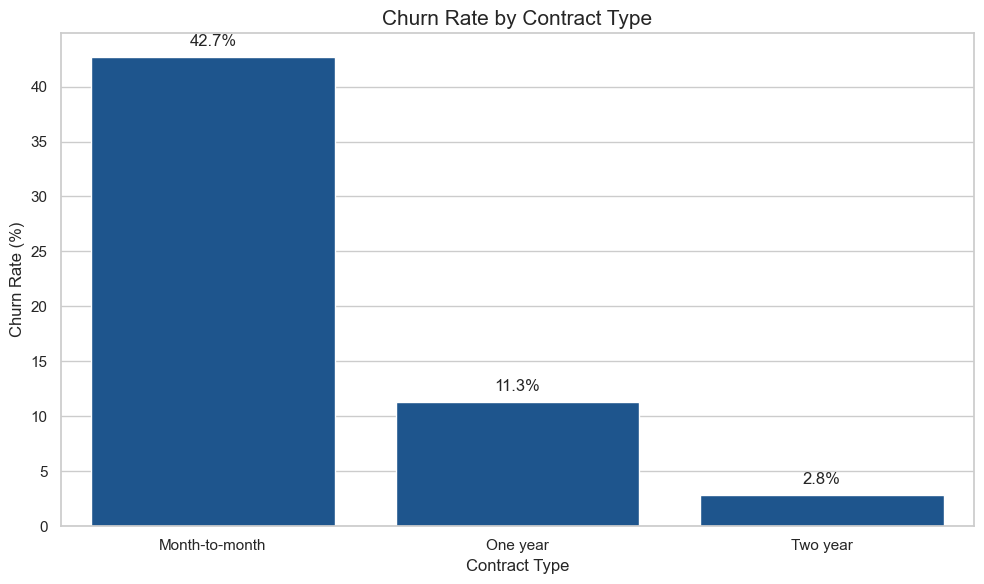

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\299161082.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  security_churn = df_clean.groupby('OnlineSecurity')['Churn'].mean() * 100


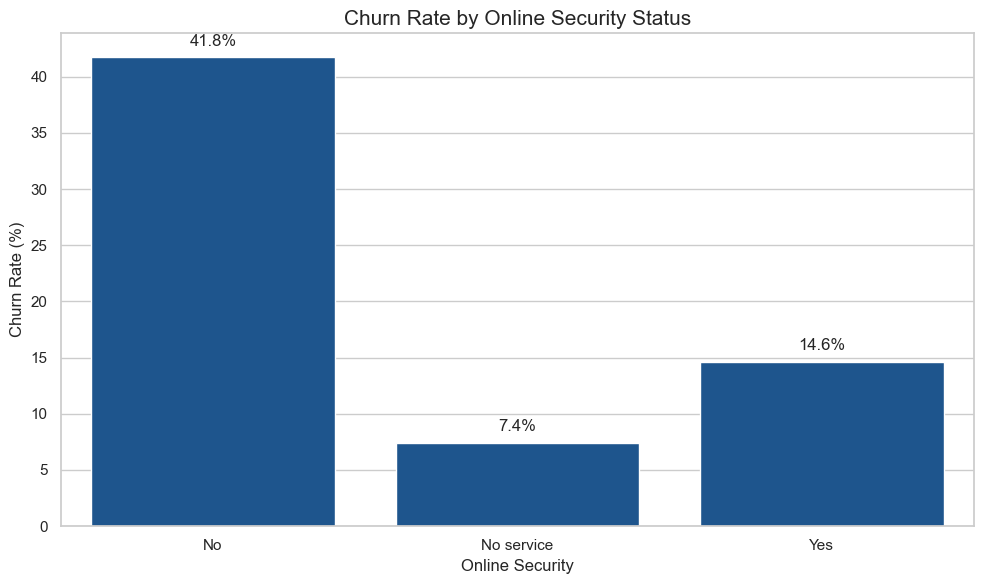

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\299161082.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tech_churn = df_clean.groupby('TechSupport')['Churn'].mean() * 100


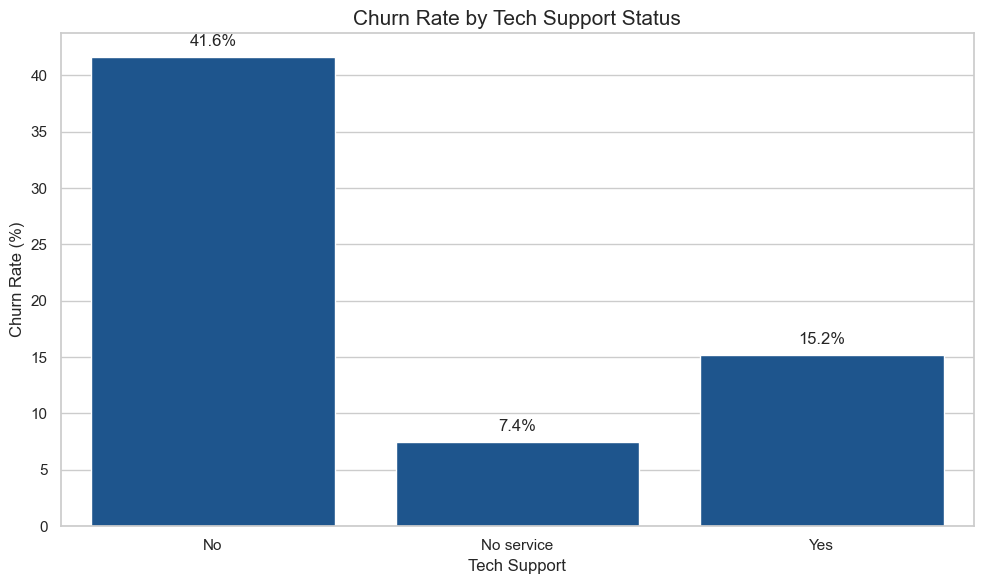

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\299161082.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  internet_churn = df_clean.groupby('InternetService')['Churn'].mean() * 100


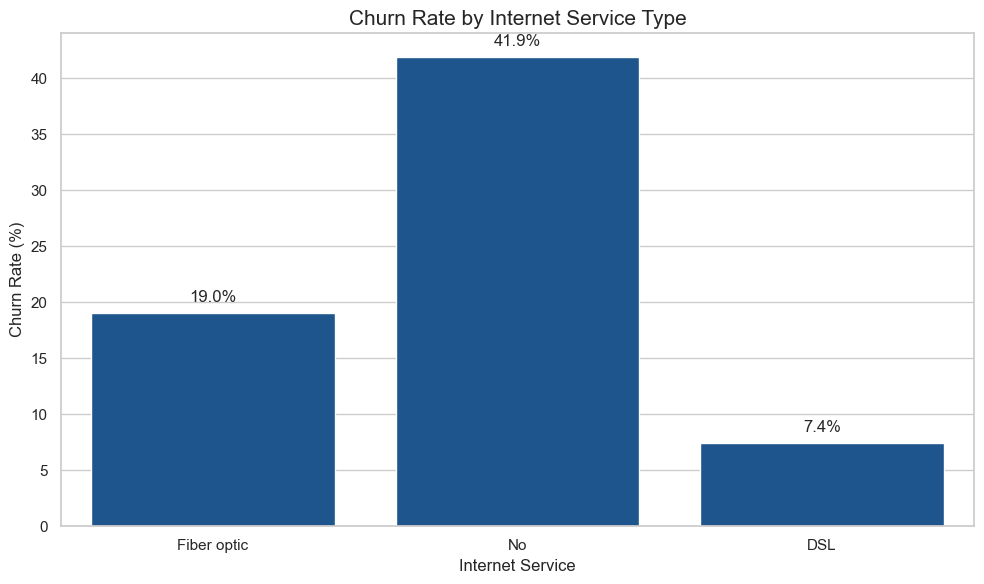

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\299161082.py:90: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = df_clean.pivot_table(


<Figure size 1400x800 with 0 Axes>

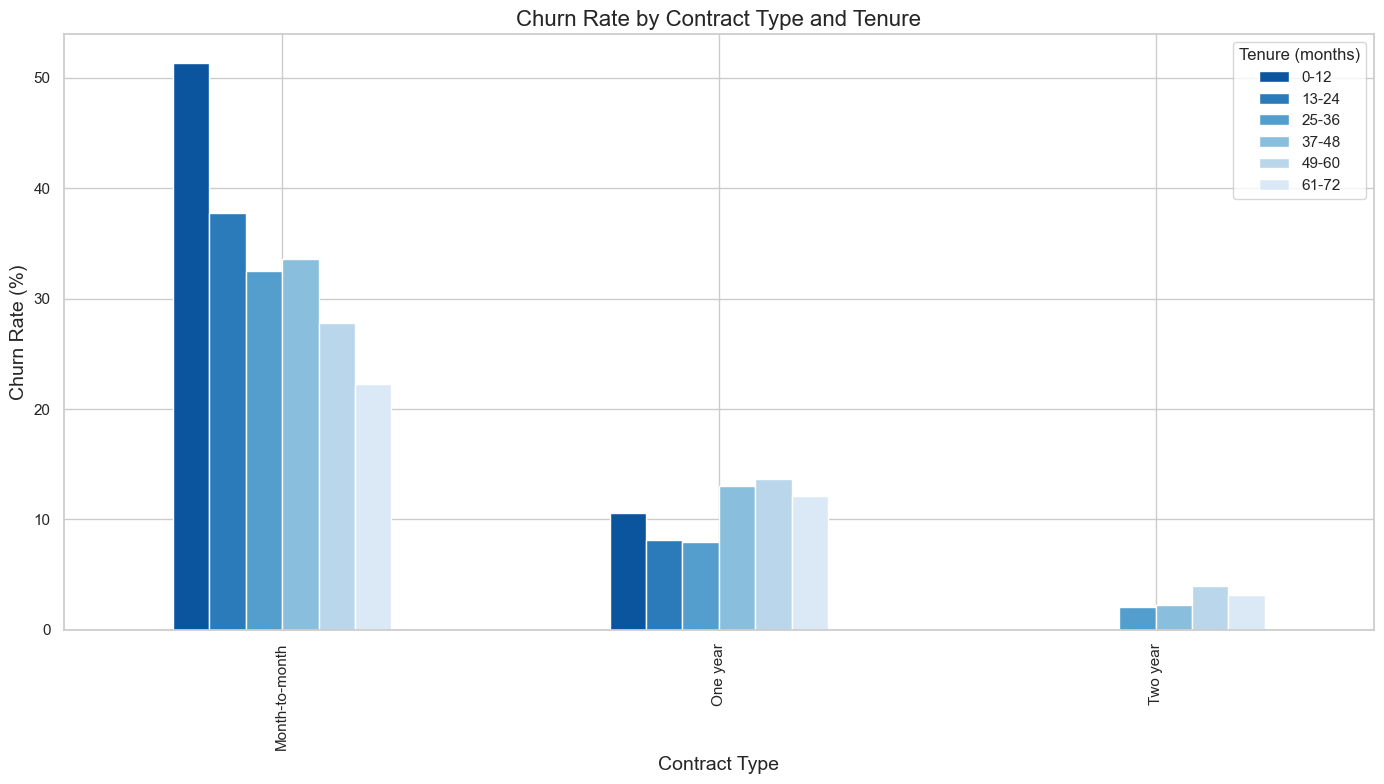

C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\299161082.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contract_churn = df_clean.groupby('Contract')['Churn'].mean() * 100
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\299161082.py:147: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  internet_churn = df_clean.groupby('InternetService')['Churn'].mean() * 100
C:\Users\ZhaoQ\AppData\Local\Temp\ipykernel_7748\299161082.py:159: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and 

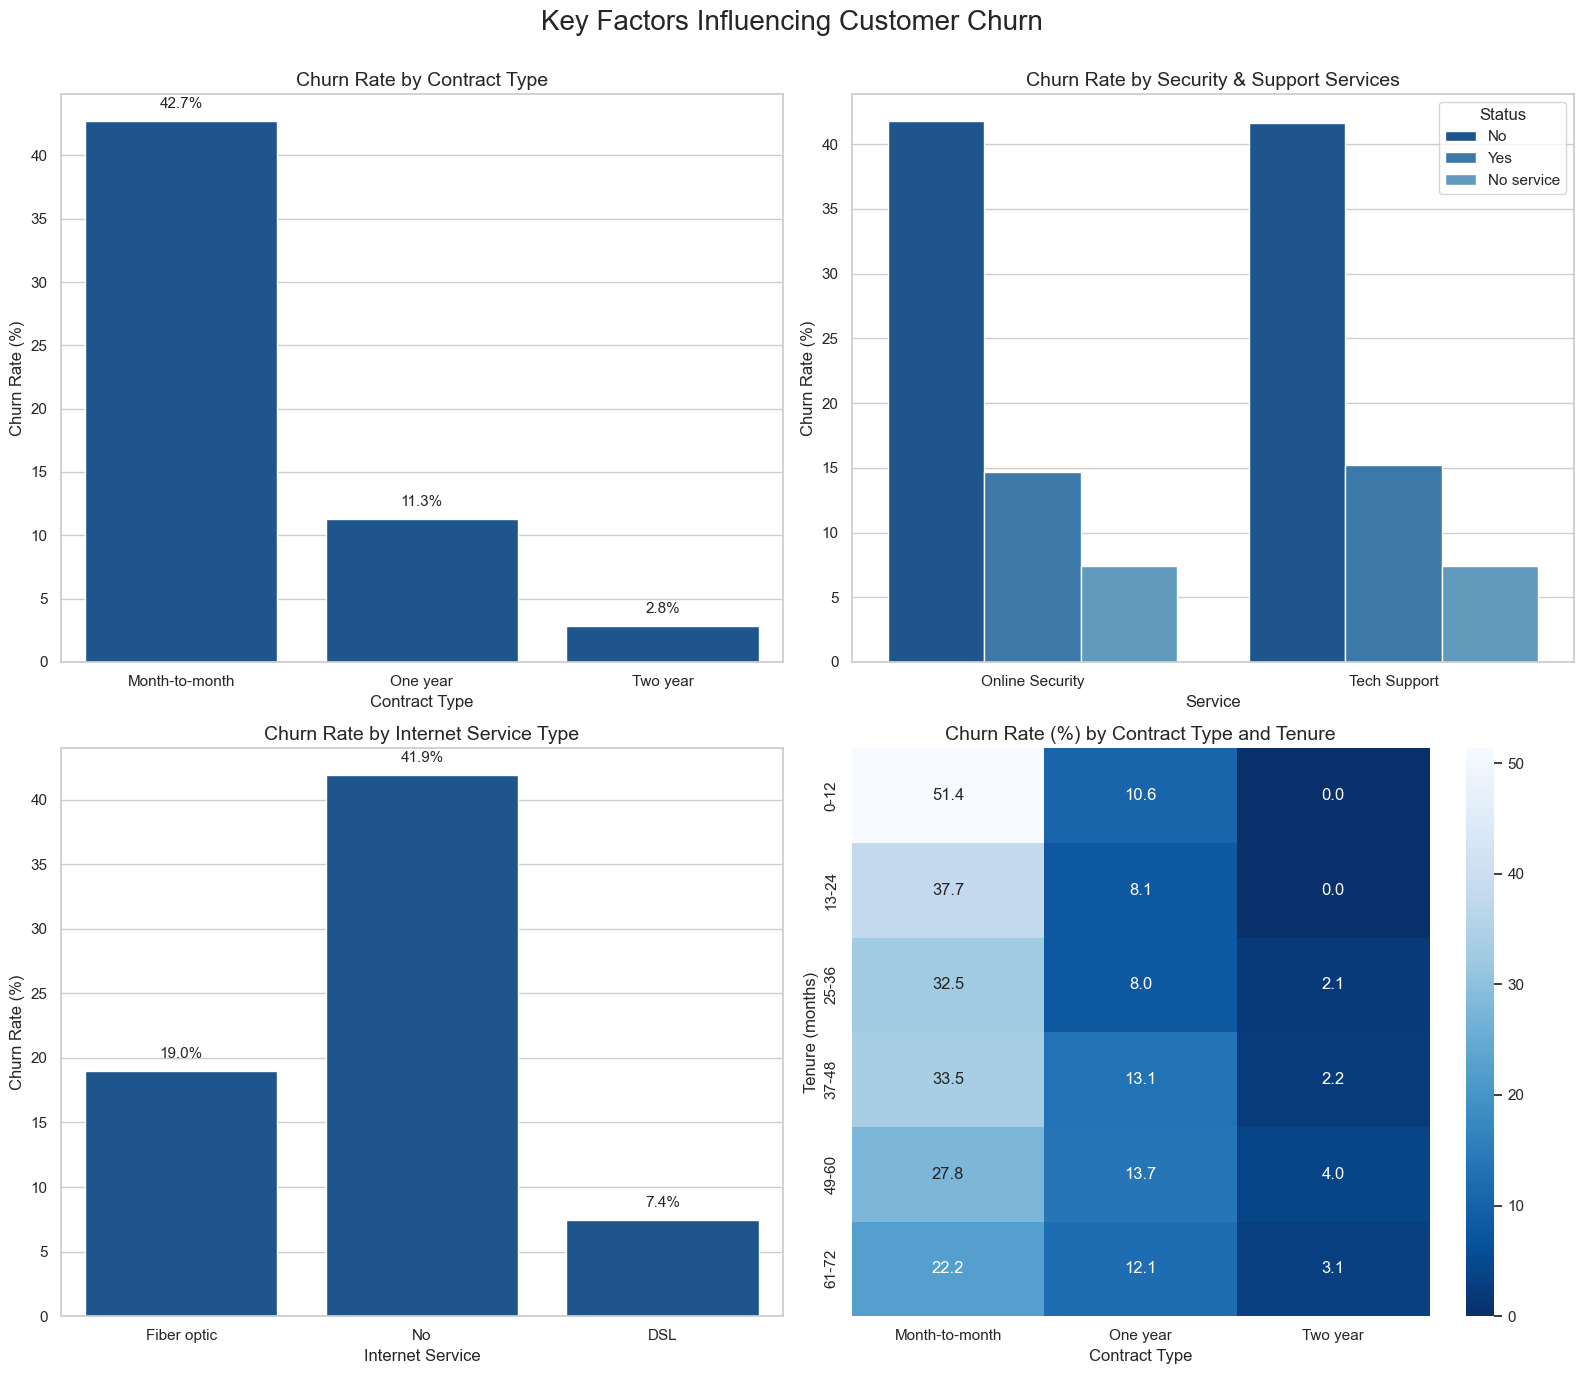

In [84]:
sns.set_theme(style="whitegrid")
sns.set_palette("Blues_r")

df_clean['Churn'] = pd.to_numeric(df_clean['Churn'])

contract_labels = {0: 'Month-to-month', 1: 'One year', 2: 'Two year'}
service_labels = {0: 'No', 1: 'Yes', 2: 'No service'}
internet_labels = {0: 'DSL', 1: 'Fiber optic', 2: 'No'}

# 1. Contract Type vs Churn Rate
plt.figure(figsize=(10, 6))
contract_churn = df_clean.groupby('Contract')['Churn'].mean() * 100
contract_churn_df = pd.DataFrame({'Churn_Rate': contract_churn})
contract_churn_df.index = [contract_labels.get(x, x) for x in contract_churn_df.index]

ax = sns.barplot(x=contract_churn_df.index, y=contract_churn_df['Churn_Rate'])
plt.title('Churn Rate by Contract Type', fontsize=15)
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

for i, v in enumerate(contract_churn_df['Churn_Rate']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
    
plt.tight_layout()
plt.savefig('contract_churn.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Online Security vs Churn Rate
plt.figure(figsize=(10, 6))
security_churn = df_clean.groupby('OnlineSecurity')['Churn'].mean() * 100
security_churn_df = pd.DataFrame({'Churn_Rate': security_churn})
security_churn_df.index = [service_labels.get(x, x) for x in security_churn_df.index]

ax = sns.barplot(x=security_churn_df.index, y=security_churn_df['Churn_Rate'])
plt.title('Churn Rate by Online Security Status', fontsize=15)
plt.xlabel('Online Security', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

for i, v in enumerate(security_churn_df['Churn_Rate']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
    
plt.tight_layout()
plt.savefig('security_churn.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Tech Support vs Churn Rate
plt.figure(figsize=(10, 6))
tech_churn = df_clean.groupby('TechSupport')['Churn'].mean() * 100
tech_churn_df = pd.DataFrame({'Churn_Rate': tech_churn})
tech_churn_df.index = [service_labels.get(x, x) for x in tech_churn_df.index]

ax = sns.barplot(x=tech_churn_df.index, y=tech_churn_df['Churn_Rate'])
plt.title('Churn Rate by Tech Support Status', fontsize=15)
plt.xlabel('Tech Support', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

for i, v in enumerate(tech_churn_df['Churn_Rate']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
    
plt.tight_layout()
plt.savefig('techsupport_churn.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Internet Service vs Churn Rate
plt.figure(figsize=(10, 6))
internet_churn = df_clean.groupby('InternetService')['Churn'].mean() * 100
internet_churn_df = pd.DataFrame({'Churn_Rate': internet_churn})
internet_churn_df.index = [internet_labels.get(x, x) for x in internet_churn_df.index]

ax = sns.barplot(x=internet_churn_df.index, y=internet_churn_df['Churn_Rate'])
plt.title('Churn Rate by Internet Service Type', fontsize=15)
plt.xlabel('Internet Service', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

for i, v in enumerate(internet_churn_df['Churn_Rate']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
    
plt.tight_layout()
plt.savefig('internet_churn.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Contract*Tenure Interaction
df_clean['Tenure_Group'] = pd.cut(
    df_clean['tenure'], 
    bins=[0, 12, 24, 36, 48, 60, 72], 
    labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'],
    include_lowest=True
)

pivot_data = df_clean.pivot_table(
    index='Contract',
    columns='Tenure_Group',
    values='Churn',
    aggfunc='mean'
) * 100

pivot_data.index = [contract_labels.get(x, x) for x in pivot_data.index]

plt.figure(figsize=(14, 8))
ax = pivot_data.plot(kind='bar', figsize=(14, 8))
plt.title('Churn Rate by Contract Type and Tenure', fontsize=16)
plt.xlabel('Contract Type', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.legend(title='Tenure (months)')

plt.tight_layout()
plt.savefig('contract_tenure_churn.png', dpi=300, bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Key Factors Influencing Customer Churn', fontsize=20, y=0.98)

# Contract Type
contract_churn = df_clean.groupby('Contract')['Churn'].mean() * 100
contract_churn_df = pd.DataFrame({'Churn_Rate': contract_churn})
contract_churn_df.index = [contract_labels.get(x, x) for x in contract_churn_df.index]

sns.barplot(x=contract_churn_df.index, y=contract_churn_df['Churn_Rate'], ax=axs[0, 0])
axs[0, 0].set_title('Churn Rate by Contract Type', fontsize=14)
axs[0, 0].set_xlabel('Contract Type', fontsize=12)
axs[0, 0].set_ylabel('Churn Rate (%)', fontsize=12)
for i, v in enumerate(contract_churn_df['Churn_Rate']):
    axs[0, 0].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=11)

# Online Security & Tech Support Combined
security_data = pd.DataFrame({
    'Service': 'Online Security',
    'Status': [service_labels.get(x, x) for x in df_clean['OnlineSecurity'].unique()],
    'Churn_Rate': [df_clean[df_clean['OnlineSecurity']==status]['Churn'].mean()*100 
                  for status in df_clean['OnlineSecurity'].unique()]
})

tech_data = pd.DataFrame({
    'Service': 'Tech Support',
    'Status': [service_labels.get(x, x) for x in df_clean['TechSupport'].unique()],
    'Churn_Rate': [df_clean[df_clean['TechSupport']==status]['Churn'].mean()*100 
                  for status in df_clean['TechSupport'].unique()]
})

combined_df = pd.concat([security_data, tech_data])
sns.barplot(x='Service', y='Churn_Rate', hue='Status', data=combined_df, ax=axs[0, 1])
axs[0, 1].set_title('Churn Rate by Security & Support Services', fontsize=14)
axs[0, 1].set_ylabel('Churn Rate (%)', fontsize=12)
axs[0, 1].legend(title='Status')

# Internet Service Type
internet_churn = df_clean.groupby('InternetService')['Churn'].mean() * 100
internet_churn_df = pd.DataFrame({'Churn_Rate': internet_churn})
internet_churn_df.index = [internet_labels.get(x, x) for x in internet_churn_df.index]

sns.barplot(x=internet_churn_df.index, y=internet_churn_df['Churn_Rate'], ax=axs[1, 0])
axs[1, 0].set_title('Churn Rate by Internet Service Type', fontsize=14)
axs[1, 0].set_xlabel('Internet Service', fontsize=12)
axs[1, 0].set_ylabel('Churn Rate (%)', fontsize=12)
for i, v in enumerate(internet_churn_df['Churn_Rate']):
    axs[1, 0].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=11)

# Contract * Tenure Heatmap
pivot_tenure_contract = pd.pivot_table(
    df_clean,
    values='Churn',
    index='Tenure_Group',
    columns='Contract',
    aggfunc='mean'
) * 100

pivot_tenure_contract.columns = [contract_labels.get(x, x) for x in pivot_tenure_contract.columns]

sns.heatmap(pivot_tenure_contract, annot=True, fmt='.1f', cmap='Blues_r', ax=axs[1, 1])
axs[1, 1].set_title('Churn Rate (%) by Contract Type and Tenure', fontsize=14)
axs[1, 1].set_xlabel('Contract Type', fontsize=12)
axs[1, 1].set_ylabel('Tenure (months)', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('churn_factors_combined.png', dpi=300, bbox_inches='tight')
plt.show()